# <font color = red> ToDo: </font>
 
* <font color = red>consolidate imports</font>
* <font color = red>replace any remaining keras elements with own implementation</font>
* <font color = red>look up diagonal affine transform (normalization layer)</font>


# Bachelorarbeit 2
## Recreating ChatGPT on a miniature scale
This project builds on WFP2.
The current text corpus consists of 47 books by Arthur Conan Doyle and H.G. Wells, for which the copyright has expired.

Much inspiration for this project is drawn from the YouTube videos "Let's build GPT: from scratch, in code, spelled out." and "Let's build the GPT Tokenizer" by Andrej Karpathy.

https://www.youtube.com/watch?v=kCc8FmEb1nY

https://www.youtube.com/watch?v=zduSFxRajkE

# 1. Loading the data

There are two options available to import the dataset:
*   from Google Drive, by mounting it into the Google Colab workspace
*   via the public link to the dataset file

## 1.1 import dataset into notebook

In [1]:
# !pip install regex
# !pip install pandas

'''
Installing tensorflow packages

Note: CUDA and cuDNN installed separately in Anaconda prompt with command:
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

Note 2: outdated versions of tensorflow, numpy, CUDA and cuDNN, as well as
python <=3.10 need to be used because tensorflow dropped GPU support for
native Windows after version 2.10
'''
# !pip install "tensorflow<2.11"
# !pip uninstall numpy --yes
# !pip install "numpy<2.0"
# !pip install matplotlib

'\nInstalling tensorflow packages\n\nNote: CUDA and cuDNN installed separately in Anaconda prompt with command:\nconda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0\n\nNote 2: outdated versions of tensorflow, numpy, CUDA and cuDNN, as well as\npython <=3.10 need to be used because tensorflow dropped GPU support for\nnative Windows after version 2.10\n'

In [2]:
import os
# from google.colab import drive
# import zipfile

# set source option
# - "link" to download from shared link
# - "google_drive" to get data by mounting google drive

# dataset version:
dataset = "dataset_v1"
'''
source = "local"

if source == "google_drive":
  # mount google drive
  drive.mount('/content/drive')

  basePath = "/content/drive/MyDrive/MiniChatGPT/"

elif source == "link":
  basePath = "/content/"
  # download file from link
  !wget "https://drive.google.com/uc?export=download&id=1IK1_p6Prk11l6JlzSJuXIAHdhIKmmrt9" -O dataset_v1.zip
  # extract the files
  zip_ref = zipfile.ZipFile('dataset_v1.zip', 'r')
  zip_ref.extractall('/content/' + dataset)
  zip_ref.close()
  
else:
  print("!!WARNING!!: unknown data source type!")
'''

basePath = "./"

# check datset contents
for dirpath, dirnames, filenames in os.walk(basePath + dataset):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 2 directories and 0 files in './dataset_v1'.
There are 1 directories and 2 files in './dataset_v1\Arthur Conan Doyle'.
There are 0 directories and 9 files in './dataset_v1\Arthur Conan Doyle\Sherlock Holmes'.
There are 0 directories and 36 files in './dataset_v1\HG Wells'.


In [3]:
# open and display the first lines of one file
for dirpath, dirnames, filenames in os.walk(basePath + dataset):
  if len(filenames) > 0:
    with open (dirpath + "/" + filenames[0], "r", encoding="utf-8") as f:
      first_file = f.read()
    break

print(first_file[:800])

The Project Gutenberg eBook of The Lost World
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: The Lost World


Author: Arthur Conan Doyle

Release date: June 1, 1994 [eBook #139]
                Most recently updated: January 1, 2021

Language: English

Credits: Produced by Judith Boss.  HTML version by Al Haines.


*** START OF THE PROJECT GUTENBERG EBOOK THE LOST WORLD ***




Produced b


## 1.2 load all books

In [4]:
book_corpus = list()
for dirpath, dirnames, filenames in os.walk(basePath + dataset):
  for file in filenames:
    file_path = os.path.join(dirpath, file)
    with open (file_path, "r", encoding="utf-8") as f:
      book_corpus.append(f.read())

In [5]:
# check loaded data
print(f"Books in corpus: {len(book_corpus)}")

total_characters = 0

for book in book_corpus:
  print(book[:book.find("\n")])
  total_characters += len(book)

print(f"\nTotal number of characters in corpus: {total_characters}")

Books in corpus: 47
The Project Gutenberg eBook of The Lost World
The Project Gutenberg eBook of The Poison Belt
The Project Gutenberg eBook of A Study in Scarlet
The Project Gutenberg eBook of His Last Bow: An Epilogue of Sherlock Holmes
The Project Gutenberg eBook of Adventures of Sherlock Holmes
The Project Gutenberg eBook of The case-book of Sherlock Holmes
The Project Gutenberg eBook of The Hound of the Baskervilles
The Project Gutenberg eBook of The Memoirs of Sherlock Holmes
The Project Gutenberg eBook of The Return of Sherlock Holmes
The Project Gutenberg eBook of The Sign of the Four
The Project Gutenberg eBook of The Valley of Fear
The Project Gutenberg eBook of 30 Strange Stories
The Project Gutenberg eBook of A Modern Utopia
The Project Gutenberg eBook of Ann Veronica: A Modern Love Story
The Project Gutenberg eBook of Bealby; A Holiday
The Project Gutenberg eBook of Boon, The Mind of the Race, The Wild Asses of the Devil, and The Last Trump;
The Project Gutenberg eBook of 

# 2. Pre-Processing
## 2.1 remove disclaimers and metadata from the files

Project Gutenberg files include copyright disclaimers, metadata and information about Project Gutenberg before and after the book text.

The beginning and end of a book are marked with

\*** START OF THE PROJECT GUTENBERG EBOOK [BOOK TITLE] ***

and

\*** END OF THE PROJECT GUTENBERG EBOOK [BOOK TITLE] ***

In [6]:
gutenberg_start_string = "*** START OF THE PROJECT GUTENBERG EBOOK"
gutenberg_end_string = "*** END OF THE PROJECT GUTENBERG EBOOK"

# takes in a string containing the raw text of a Project Gutenberg ebook
# cut everything up to and including the line containing the start string
# cute evreything after and including the line containg the end string
def cut_gutenberg_disclaimers(book_text):
  # get first line of string
  # should be of shape "The Project Gutenberg eBook of [Book Title]"
  first_line = book_text[:book_text.find("\n")]

  # get book title
  if first_line.find("eBook of ") == -1:
    book_title = "title not found"
  else:
    title_start_index = first_line.find("eBook of ") + len("eBook of ")
    book_title = first_line[title_start_index:]

  # find beginning of book text
  start_index = book_text.find(gutenberg_start_string)
  if start_index == -1:
    print("!!WARNING!!: Start string not found in text!!")
    print("First line of book: " + first_line)
    start_index = 0
  else:
    end_of_line_index = book_text.find("\n", start_index)
    if end_of_line_index == -1:
      print("!!WARNING!!: No linebreak found after start string!!")
      print("First line of book: " + first_line)
    else:

      # set start_index to beginning of next line
      start_index = end_of_line_index + 1;

  # find end of book text
  end_index = book_text.find(gutenberg_end_string)
  if end_index != -1:
    end_index = book_text.rfind("\n", 0, end_index)
  if end_index == -1:
    print("!!WARNING!!: End string not found or was in first line of text!!")
    print("First line of book: " + first_line)
    end_index = len(book_text)

  # trim book
  book_text = book_text[start_index:end_index]

  # verify that all disclaimers have been removed:
  duplicate_disclaimer = book_text.find("THE PROJECT GUTENBERG EBOOK")
  if(duplicate_disclaimer != -1):
    print(f"!!WARNING!!: Duplicate marker found at position {duplicate_disclaimer}!!")
    print("First line of book: "+ first_line)

  return book_title, book_text

## ~2.2 Clean input data~
<font color='crimson'>Leave in for now! See comments in 3.1!</font>

~The input data turned out to contain a number of special characters that are either semantcal duplicates (e.g.: different UTF double quote characters), or no longer carry information after removal of formatting (see 3.1).~

~To reduce the amount of noise in the data, the decision was made to standardize quotation marks. All other special characters are left in for now.~


In [7]:
'''
import regex as re

# clean data by replacing or removing specific special characters
def replace_quotation_characters(book_text):
  # pattern to match any version of double quotes, including two consecutive single quotes
  # note: the latter could be prone to unintendedly capture typographic errors
  d_quote_rx = r'[“”„‟‶″]|\'\''

  # pattern to match all versions of single quote characters
  s_quote_rx = r'[‘’‚‛′]'

  book_text = re.sub(d_quote_rx, '\"', book_text)
  book_text = re.sub(s_quote_rx, '\'', book_text)

  return book_text
'''

'\nimport regex as re\n\n# clean data by replacing or removing specific special characters\ndef replace_quotation_characters(book_text):\n  # pattern to match any version of double quotes, including two consecutive single quotes\n  # note: the latter could be prone to unintendedly capture typographic errors\n  d_quote_rx = r\'[“”„‟‶″]|\'\'\'\n\n  # pattern to match all versions of single quote characters\n  s_quote_rx = r\'[‘’‚‛′]\'\n\n  book_text = re.sub(d_quote_rx, \'"\', book_text)\n  book_text = re.sub(s_quote_rx, \'\'\', book_text)\n\n  return book_text\n'

## 2.3 remove consecutive whitespaces and line breaks

Plaintext books usually use whitespaces and line breaks to achieve formatting. These include:
*   consecutive whitespaces to justify or align text
*   line breaks within paragraphs to simulate page width
*   consecutive line breaks, e.g. on the title page orbetween chapters.

Project Gutenberg books further contain underscores to mark beginning and end of italic text.

Text formatting is not within the scope of this project, therefore these will all be replaced or removed. This includes, at least initially, removing all line breaks entirely.

Note: this could make the table of contents at the start of many books more confusing for the model. Removing it does, however, prove challenging due to different formatting styles.

In [8]:
import regex as re

def remove_formatting(book_text):
  # remove italics markers
  book_text = re.sub(r'_', '', book_text)

  # add a space as the first character
  # the purpose is that the first word of a text should not be percieved
  # differently by the tokenizer than the same word occuring later in the
  # text, where it will always be preceeded by a space character.
  book_text = " " + book_text

  # replace all whitespace (line breaks, spaces and tabs) with single spaces
  book_text = re.sub(r'\s+', ' ', book_text)

  return book_text

In [9]:
# run all preprocesssing steps on one book text
def preprocess_gutenberg_book(book_text):
  book_title, book_text = cut_gutenberg_disclaimers(book_text)
  book_text = remove_formatting(book_text)

  return book_title, book_text

In [10]:
import textwrap

# test preprocessing

test_title, test_text = preprocess_gutenberg_book(book_corpus[0])
print("Book title: " + test_title)
print("\n".join(textwrap.wrap(test_text[:1000], break_long_words=False)))

Book title: The Lost World
 Produced by Judith Boss. HTML version by Al Haines. THE LOST WORLD I
have wrought my simple plan If I give one hour of joy To the boy who's
half a man, Or the man who's half a boy. The Lost World By SIR ARTHUR
CONAN DOYLE COPYRIGHT, 1912 Foreword Mr. E. D. Malone desires to state
that both the injunction for restraint and the libel action have been
withdrawn unreservedly by Professor G. E. Challenger, who, being
satisfied that no criticism or comment in this book is meant in an
offensive spirit, has guaranteed that he will place no impediment to
its publication and circulation. Contents CHAPTER I. "THERE ARE
HEROISMS ALL ROUND US" II. "TRY YOUR LUCK WITH PROFESSOR CHALLENGER"
III. "HE IS A PERFECTLY IMPOSSIBLE PERSON" IV. "IT'S JUST THE VERY
BIGGEST THING IN THE WORLD" V. "QUESTION!" VI. "I WAS THE FLAIL OF THE
LORD" VII. "TO-MORROW WE DISAPPEAR INTO THE UNKNOWN" VIII. "THE
OUTLYING PICKETS OF THE NEW WORLD" IX. "WHO COULD HAVE FORESEEN IT?"
X. "THE MOST WON

In [11]:
import pandas as pd

# Adjusting pandas display settings to make printed dataframes more readable
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.width', 200)

# create empty list for preprocessed book data
preprocessed_books = []
for i in range(len(book_corpus)):
  book_title, book_text = preprocess_gutenberg_book(book_corpus[i])
  preprocessed_books.append({"book_title": book_title, "book_text": book_text})

# convert list to pandas dataframe
books_df = pd.DataFrame(preprocessed_books)

# check contents of df
print("DataFrame Shape:", books_df.shape)
print(books_df.head())

DataFrame Shape: (47, 2)
                                     book_title                                                                        book_text
0                                The Lost World   Produced by Judith Boss. HTML version by Al Haines. THE LOST WORLD I have w...
1                               The Poison Belt   THE POISON BELT BY ARTHUR CONAN DOYLE Being an account of another adventure...
2                            A Study in Scarlet   A STUDY IN SCARLET By A. Conan Doyle CONTENTS A STUDY IN SCARLET. PART I. C...
3  His Last Bow: An Epilogue of Sherlock Holmes   cover His Last Bow by Arthur Conan Doyle Preface The friends of Mr. Sherloc...
4                 Adventures of Sherlock Holmes   Produced by The Online Distributed Proofreading Team at http://www.pgdp.net...


# 3. Tokenization
### <font color='crimson'> <b><u>Disclaimer:</u></b> Parts of this chapter are based on, or adapted from the YouTube video "Let's build the GPT Tokenizer" by Andrej Karpathy.</font>

Eternal glory goes to anyone who can delete tokenization as a required step in LLMs.

Video: https://www.youtube.com/watch?v=zduSFxRajkE

GitHub: https://github.com/karpathy/minbpe/tree/master

Google Colab Notebook: https://colab.research.google.com/drive/1y0KnCFZvGVf_odSfcNAws6kcDD7HsI0L?usp=sharing



## 3.1 compiling the character vocabulary

Note: The character vocabulary turned out to contain a number of of more unusual special characters, the meaning and relevance of which is not immeadiately clear. It could be beneficial to revise the pre-processing step in the future, to exclude (some of) these.

Original character vocabulary:<br>
" !"$&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^abcdefghijklmnopqrstuvwxyz{|}~£§°¶·º½¾ÆÈÉ×àáâäæçèéêëîïñóôö÷ûüāōœαβ–—‘’“”…′″─│┌┐└┘├┤┼║▼・"

In [12]:
complete_text = ' '.join(books_df["book_text"])
unique_characters = sorted(list(set(complete_text)))

print("Characters in corpus:")
print(''.join(unique_characters))

Characters in corpus:
 !"$&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^abcdefghijklmnopqrstuvwxyz{|}~£§°¶·º½¾ÆÈÉ×àáâäæçèéêëîïñóôö÷ûüāōœαβ–—‘’“”…′″─│┌┐└┘├┤┼║▼・


Exploring the dataset further to identify Books containing specific special characters.

In [13]:
# find special characters in books
character = '@'
for index, row in books_df.iterrows():
  index = row.iloc[1].find(character)
  if index != -1:
    # if character found, print the surrounding text passage
      start = max(0, index - 20)
      end = min(len(row.iloc[1]), index + 21)
      print(f"Character {character} found in book {row.iloc[0]}: {row.iloc[1][start:end]}")

Character @ found in book The Hound of the Baskervilles: P. K.Pehtla <ppehtla@nfld.com> The Hound 
Character @ found in book The Secret Places of the Heart:  kings and churches-@-and Corinthian capi


A search of the book corpus for some of the more unusual characters at the end of sequence above revealed that most of them are only present in a single book each. In particular, all the characters "─│┌┐└┘├┤┼║▼" appear only in a single book, **"Joan and Peter: The story of an education"**, where they are used to draw tables and diagrams.

As such, they most likely contain no information relevant for the scope of this project, especially since formatting by whitespace is removed, breaking the structure of these depictions.

Consequently, it seems worth to consider whether or not to omit these symbols from the dataset, as they can be expected to only contribute noise. This could either be achieved by removing them during pre-processing, or by removing them from the base vocabulary, to be replaced by the "unknown" token. This is a special token which is used when an unknown character is encountered during input tokenization. Since this version of the project is using a non-byte-level variant of the Byte Pair Encoder, inclusion of the "unknown" token is highly advisable in any case.

On the other hand, since these symbols are restricted to short sections of a single input text, their detrimental influence on model training is likely low to negligible, while over-specific preprocessing could be considered to run somewhat counter to the idea of training an LLM on a large amount of diverse input texts.

A better case could be made for unifying the different types of single and double quotation marks:
- replacing <font face="Rage" size=5>“</font> and <font face="Rage" size=5>”</font> with <font face="Rage" size=5>"</font>
- replacing <font face="Rage" size=5>‘</font> and <font face="Rage" size=5>’</font> with <font face="Rage" size=5>'</font>

These pre-processing steps would be more generally applicable and therefor easier to justify. However, these sets of symbols could potentially also serve as an interesting example to compare token embeddings. They serve the same purpose in written text - to mark a quote or piece of dialog, but convey a different amount of information rgarding their relative position to the quote (before the quote, after the quote, or on either side).

##3.2 Byte-Pair-Encoding (BPE) tokenizer
BPE starts with a small base dictionary of tokens, adding new ones by merging couples of tokens, based on how common they appear in the text. Contrary to the name, BPE does not necessarily work on the level of bytes, but originally on the level of characters.

This is a non-byte-level version of BPE. A byte-level BPE will possibly be implemented in a future model version.

In [14]:
# convert list of characters into two dictionaries, mapping tokens (strings)
# to their IDs, with IDs starting at 0.

# create base-token to ID dictionary
# this will only contain the original single-character tokens. New tokens will
# not be appended and instead collected in a list in order of their creation.
# this is necessary to ensure that during encoding token pairs are merged
# in the same way as during training of the tokenizer.
token_to_id_dict = {token: id for id, token in enumerate(unique_characters, start=0)}

# create List for merged tokens in the order of their creation
# merged pairs are stored as tuples. Their id is their index in the list + the
# number of elements of the base-dictionary.
# e.g.: if the base dictionary contains 80 elements, then the last token-ID in
# base dictionary is 79, the first token-ID created by merges is 80.
merges = []

# create ID to base-token dictionary (inverting the token_to_id_dict dictionary)
# this is for decoding a sequence of IDs from the base-dictionary (i.e.: those
# representing single characters) into a string
id_to_token_dict = {id: token for token, id in token_to_id_dict.items()}
print(token_to_id_dict)
print(id_to_token_dict)

{' ': 0, '!': 1, '"': 2, '$': 3, '&': 4, "'": 5, '(': 6, ')': 7, '*': 8, '+': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '<': 26, '=': 27, '>': 28, '?': 29, '@': 30, 'A': 31, 'B': 32, 'C': 33, 'D': 34, 'E': 35, 'F': 36, 'G': 37, 'H': 38, 'I': 39, 'J': 40, 'K': 41, 'L': 42, 'M': 43, 'N': 44, 'O': 45, 'P': 46, 'Q': 47, 'R': 48, 'S': 49, 'T': 50, 'U': 51, 'V': 52, 'W': 53, 'X': 54, 'Y': 55, 'Z': 56, '[': 57, '\\': 58, ']': 59, '^': 60, 'a': 61, 'b': 62, 'c': 63, 'd': 64, 'e': 65, 'f': 66, 'g': 67, 'h': 68, 'i': 69, 'j': 70, 'k': 71, 'l': 72, 'm': 73, 'n': 74, 'o': 75, 'p': 76, 'q': 77, 'r': 78, 's': 79, 't': 80, 'u': 81, 'v': 82, 'w': 83, 'x': 84, 'y': 85, 'z': 86, '{': 87, '|': 88, '}': 89, '~': 90, '£': 91, '§': 92, '°': 93, '¶': 94, '·': 95, 'º': 96, '½': 97, '¾': 98, 'Æ': 99, 'È': 100, 'É': 101, '×': 102, 'à': 103, 'á': 104, 'â': 105, 'ä': 106, 'æ': 107, 'ç': 108, 'è': 109, 'é': 110

### Splitting the text data into words
A first approach to feed the entire dataset into the tokenizer as a single char sequence led to many tokens containing inner spaces. These tokens can be expected to perform worse at capturing meaning, except when encoding complete phrases of multiple words. One way to prevent this, is to split the input sequence into words, with the space character used as spearator.

On the other hand, if space characters are kept during the splitting process, they can be used to capture start-of-word and end-of-word information. Keeping the space at the start of each word is the approach used by the GPT-2 tokenizer and will also be employed here (<font color='red'>!! insert citation !!</font>).

Further, the paper introducing the GPT-2 model describes an issue that arose with puctuation characters, where multiple tokens would be coined from the same common word in combination with different punctuation symbols. For example, the word "dog" would show up in multiple tokens as " dog", " dog.", " dog?", etc. This is a problem both because it dilutes or inflates the token dictionary and also needlessly requires the LLM to learn to equate these tokens. This issue can be counteracted by further splitting the character sequence to separate punctuation from words.

This project will use the same RegEx string for word separation as the GPT-2 tokenizer, adapted to make detection of contractions non-case sensitive, as suggested in the accompanying code repository (https://github.com/openai/gpt-2/blob/master/src/encoder.py)

In [15]:
def split_input_string(input):
  # RegEx string for splitting input string
  split_pattern = r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""

  # split input string into a list of substrings (referred to as "words")
  # according to RegEx pattern
  words = re.findall(split_pattern, input, re.IGNORECASE)

  return words

In [16]:
# test input splitting
splitting_test = split_input_string("What's this? IT'S a test string!! 1234")
print(splitting_test)

['What', "'s", ' this', '?', ' IT', "'S", ' a', ' test', ' string', '!!', ' 1234']


In [17]:
# split entire dataset into words
complete_ds_split = split_input_string(complete_text)

# check output
print(f"Nr. of sub-strings: {len(complete_ds_split)}")
print("Excerpt of sub-strings:")
print(complete_ds_split[1100:1200])

Nr. of sub-strings: 4655578
Excerpt of sub-strings:
[' can', "'t", ' imagine', ' how', ' that', ' official', ' came', ' into', ' the', ' matter', ';', ' but', ' in', ' he', ' trotted', ',', ' and', ' set', ' us', ' both', ' laughing', '.', ' "', 'That', ' does', ' not', ' satisfy', ' me', ' in', ' the', ' least', '.', ' I', ' want', ' my', ' arms', ' round', ' you', ',', ' and', ' your', ' head', ' on', ' my', ' breast', ',', ' and', '--', 'oh', ',', ' Gladys', ',', ' I', ' want', '----"', ' She', ' had', ' sprung', ' from', ' her', ' chair', ',', ' as', ' she', ' saw', ' signs', ' that', ' I', ' proposed', ' to', ' demonstrate', ' some', ' of', ' my', ' wants', '.', ' "', 'You', "'ve", ' spoiled', ' everything', ',', ' Ned', ',"', ' she', ' said', '.', ' "', 'It', "'s", ' all', ' so', ' beautiful', ' and', ' natural', ' until', ' this', ' kind', ' of', ' thing']


### Initial translation of characters to base dictionary token IDs

In [18]:
# takes list of "words" and converts them to list of lists of base token IDs
def base_encoding(string_list, base_encoding_dict):
  tokenized_list = []
  # go through all strings in the list
  for word in string_list:
    # translate chars in sub-string
    # TODO: add "unknown" token to dictionary and add as "else" to this line
    tokenized_word = [base_encoding_dict[char] for char in word if char in base_encoding_dict]
    tokenized_list.append(tokenized_word)
  return tokenized_list

In [19]:
# test base encoding
test_base_encoding = base_encoding(splitting_test, token_to_id_dict)
print(splitting_test)
print(test_base_encoding)

['What', "'s", ' this', '?', ' IT', "'S", ' a', ' test', ' string', '!!', ' 1234']
[[53, 68, 61, 80], [5, 79], [0, 80, 68, 69, 79], [29], [0, 39, 50], [5, 49], [0, 61], [0, 80, 65, 79, 80], [0, 79, 80, 78, 69, 74, 67], [1, 1], [0, 15, 16, 17, 18]]


### Counting token pairs and merging

In [20]:
# iterate pairwise over tokens IDs in a list of tokenized "words", counting how
# often each token pair occurs over the whole list
def count_pairs(tokenized_words, pair_counts=None):
  # Note: if no previous counts are passed as parameter, all token-pairs are
  # counted from scratch for each iteration.
  # This could probably be dramatically optimized by keeping counts, updating
  # these during merging, and then only recounting pairs involving the newly
  # created tokens
  if pair_counts == None:
    pair_counts = {}

  # iterate over every tokenized "word" in the list.
  for tokenized_word in tokenized_words:
    # iterate consecutive elements in the tokenized word, grouping each pair
    # into a tuple
    for token_id_pair in zip(tokenized_word, tokenized_word[1:]):
      # if token_id_pair is already in list, increase its count by one,
      # otherwise add it to the list
      pair_counts[token_id_pair] = pair_counts.get(token_id_pair, 0) + 1
  return pair_counts

In [21]:
test_pair_count = count_pairs(test_base_encoding)
print("Token pairs for test string:")
print(test_pair_count)
print(f"Most common pair: {max(test_pair_count, key = lambda i: test_pair_count[i])}")

Token pairs for test string:
{(53, 68): 1, (68, 61): 1, (61, 80): 1, (5, 79): 1, (0, 80): 2, (80, 68): 1, (68, 69): 1, (69, 79): 1, (0, 39): 1, (39, 50): 1, (5, 49): 1, (0, 61): 1, (80, 65): 1, (65, 79): 1, (79, 80): 2, (0, 79): 1, (80, 78): 1, (78, 69): 1, (69, 74): 1, (74, 67): 1, (1, 1): 1, (0, 15): 1, (15, 16): 1, (16, 17): 1, (17, 18): 1}
Most common pair: (0, 80)


In [22]:
# merge a specified token pair for all tokenized words in a sequence and
# return the updated sequence
def merge_tokens(tokenized_words, token_pair, new_token_id):
  updated_words = []
  for tokenized_word in tokenized_words:
    if token_pair in list(zip(tokenized_word, tokenized_word[1:])):
      # tokenized word contains this pair at least once
      merged_word = []
      i = 0 # index of current token-id in current tokenized word
      last_i = len(tokenized_word) -1 # last valid index

      # loop through the tokenized word to find instances of searched pair
      # note: (re-)using the pairs found by the zip function is tricky, as
      # instances might overlap, e.g. when the word was "aaa" and the pair to
      # be merged is "aa". The zipped list of pairs contains two matches, but
      # the first meger "destroys" the second pair
      while i < last_i:
        if tokenized_word[i] == token_pair[0] and tokenized_word[i+1] == token_pair[1]:
          # we found an instance of the pair to be merged
          # append the new token-id
          merged_word.append(new_token_id)
          # increase i by 2, as we just processed two tokens
          i += 2
        else:
          # pair did not match -> append original token-id
          merged_word.append(tokenized_word[i])
          i += 1
      if i == last_i:
        # the last token-id in the tokenized word was NOT part of a merger
        # (otherwise i would have been increase past last_i) and therefore
        # must also be appended
        merged_word.append(tokenized_word[i])

      # add newly created token-id sequence to updated list of tokenized words,
      # in place of the original one that was just processed
      updated_words.append(merged_word)

    else:
      # tokenized word did NOT contain the pair to be merged and can be
      # transferred to the updated list as is
      updated_words.append(tokenized_word)

  return updated_words

In [23]:
# testing merging
'''
test_pair = max(test_pair_count, key = lambda i: test_pair_count[i])
test_merges = []
test_merges.append(test_pair)
test_new_pair_id = len(token_to_id_dict) + len(test_merges) - 1
test_merged_sequence = merge_tokens(test_base_encoding, test_pair, test_new_pair_id)
print(test_pair)
print(test_base_encoding)
print(test_merged_sequence)
print(id_to_token_dict)
'''

'\ntest_pair = max(test_pair_count, key = lambda i: test_pair_count[i])\ntest_merges = []\ntest_merges.append(test_pair)\ntest_new_pair_id = len(token_to_id_dict) + len(test_merges) - 1\ntest_merged_sequence = merge_tokens(test_base_encoding, test_pair, test_new_pair_id)\nprint(test_pair)\nprint(test_base_encoding)\nprint(test_merged_sequence)\nprint(id_to_token_dict)\n'

### Train tokenizer

In [24]:
def train_tokenizer(tokenized_words_in, base_dictionary_size, total_merges = 100, merges_list = None):
  tokenized_words_out = tokenized_words_in
  if merges_list == None:
    merges_list = []

  # if this is a continuation of previous training cycles: check if input data
  # is compatible with existing token dictionary and merges list
  # highest token id in input can not be higher than highest id of defined
  # tokens
  # if a merges list already exists, the highest defined token id should be
  # present in the input data
  highest_token_id_dict = base_dictionary_size + len(merges_list) - 1
  highest_token_id_input = max(max(word) for word in tokenized_words_in if word)
  if (highest_token_id_input > highest_token_id_dict or
   (len(merges_list) != 0 and highest_token_id_input < highest_token_id_dict)):
    raise Exception("Highest token ids in data and token dictionary do not match!" +
                    f"\nis: {highest_token_id_input}" +
                    f"\nshould be: {highest_token_id_dict}")

  while len(merges_list) < total_merges:
    print("Token sequence:")
    print(tokenized_words_out[:20])
    print(f"Number of tokens: {sum(len(word) for word in tokenized_words_out)}")
    pair_counts = count_pairs(tokenized_words_out)

    if len(pair_counts) == 0:
      # there are no pairs left, every "word" in the input sequence is represented
      # by a single token each
      print(f"Token merger ran out of pairs to merge!" +
            f"Total number of merges: {len(merges_list)}")
      break

    top_pair = max(pair_counts, key = lambda i: pair_counts[i])
    print(f"Top token pair: {top_pair} with {pair_counts[top_pair]} occurences")
    merges_list.append(top_pair)
    new_token_id = base_dictionary_size + len(merges_list) - 1
    tokenized_words_out = merge_tokens(tokenized_words_out, top_pair, new_token_id)

  return merges_list, tokenized_words_out


In [25]:
# testing out the complete tokenizer training chain
'''
test_input_string = "That there! What where? This there here!! Herbert, take care, of the bare fire and the hare, so dinner can be served later"
test_input_string_split = split_input_string(test_input_string)
test_tokenized_words_in = base_encoding(test_input_string_split, token_to_id_dict)
test_merges, test_tokenized_words_out = train_tokenizer(test_tokenized_words_in, len(token_to_id_dict), 10)
print(f"\nMerges: {test_merges}")
print(test_input_string_split)
print(test_tokenized_words_in)
print(test_tokenized_words_out)
'''

'\ntest_input_string = "That there! What where? This there here!! Herbert, take care, of the bare fire and the hare, so dinner can be served later"\ntest_input_string_split = split_input_string(test_input_string)\ntest_tokenized_words_in = base_encoding(test_input_string_split, token_to_id_dict)\ntest_merges, test_tokenized_words_out = train_tokenizer(test_tokenized_words_in, len(token_to_id_dict), 10)\nprint(f"\nMerges: {test_merges}")\nprint(test_input_string_split)\nprint(test_tokenized_words_in)\nprint(test_tokenized_words_out)\n'

In [26]:
# do base encoding for entire DS
if not 'tokenized_words' in globals():
  tokenized_words = base_encoding(complete_ds_split, token_to_id_dict)
  merges = []
  print("Starting tokenizer training from scratch")


Starting tokenizer training from scratch


Note: at 10 000 merges, the most common token pairs occured 57 times in the entire dataset

In [27]:
# train tokenizer on entire DS
# merges, tokenized_words = train_tokenizer(tokenized_words, len(token_to_id_dict), 12000, merges)

In [28]:
print(token_to_id_dict)
print(id_to_token_dict)
print(merges)

{' ': 0, '!': 1, '"': 2, '$': 3, '&': 4, "'": 5, '(': 6, ')': 7, '*': 8, '+': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '<': 26, '=': 27, '>': 28, '?': 29, '@': 30, 'A': 31, 'B': 32, 'C': 33, 'D': 34, 'E': 35, 'F': 36, 'G': 37, 'H': 38, 'I': 39, 'J': 40, 'K': 41, 'L': 42, 'M': 43, 'N': 44, 'O': 45, 'P': 46, 'Q': 47, 'R': 48, 'S': 49, 'T': 50, 'U': 51, 'V': 52, 'W': 53, 'X': 54, 'Y': 55, 'Z': 56, '[': 57, '\\': 58, ']': 59, '^': 60, 'a': 61, 'b': 62, 'c': 63, 'd': 64, 'e': 65, 'f': 66, 'g': 67, 'h': 68, 'i': 69, 'j': 70, 'k': 71, 'l': 72, 'm': 73, 'n': 74, 'o': 75, 'p': 76, 'q': 77, 'r': 78, 's': 79, 't': 80, 'u': 81, 'v': 82, 'w': 83, 'x': 84, 'y': 85, 'z': 86, '{': 87, '|': 88, '}': 89, '~': 90, '£': 91, '§': 92, '°': 93, '¶': 94, '·': 95, 'º': 96, '½': 97, '¾': 98, 'Æ': 99, 'È': 100, 'É': 101, '×': 102, 'à': 103, 'á': 104, 'â': 105, 'ä': 106, 'æ': 107, 'ç': 108, 'è': 109, 'é': 110

In [29]:
import pickle

# uncomment to save tokenizer data to file
'''
tokenizer_data = {
    'base_dict_enc': token_to_id_dict,
    'base_dict_dec': id_to_token_dict,
    'merges': merges,
    'train_token_sequence_cache': tokenized_words # stored to allow continuation of tokenizer training
}

with open(basePath + 'tokenizer_data.pickle', 'wb') as file:
  pickle.dump(tokenizer_data, file, pickle.HIGHEST_PROTOCOL)
'''

"\ntokenizer_data = {\n    'base_dict_enc': token_to_id_dict,\n    'base_dict_dec': id_to_token_dict,\n    'merges': merges,\n    'train_token_sequence_cache': tokenized_words # stored to allow continuation of tokenizer training\n}\n\nwith open(basePath + 'tokenizer_data.pickle', 'wb') as file:\n  pickle.dump(tokenizer_data, file, pickle.HIGHEST_PROTOCOL)\n"

In [30]:
import pickle

# uncomment to load tokenizer data from file

with open(basePath + 'tokenizer_data.pickle', 'rb') as file:
    tokenizer_data = pickle.load(file)

token_to_id_dict = tokenizer_data['base_dict_enc']
id_to_token_dict = tokenizer_data['base_dict_dec']
merges = tokenizer_data['merges']
tokenized_words = tokenizer_data['train_token_sequence_cache']


In [31]:
print(len(merges))
print(sum(len(word) for word in tokenized_words))
print(max(max(word) for word in tokenized_words if word))

12000
5136441
12147


<font color = orange>Note: for inclusion of special tokens, the input string must first be split by special tokens. The remaining text chunks are then fed into the standard split function.</font>

In [32]:
# encoder

# tokenized_word = [base_encoding_dict[char] for char in word if char in base_encoding_dict]
def encode_optimized(input_string, base_dict_enc, merges_list):
    input_string_split = split_input_string(input_string)
    word_cache = {}
    input_string_encoded = []
    total_word_count = len(input_string_split)
    current_word_count = 0
    # print(f"total 'words' in string: {total_word_count}")
    report_encode_percentage = 10
    
    for word in input_string_split:
        current_word_count +=1
        if (total_word_count > 1000 and current_word_count * 100 / total_word_count >= report_encode_percentage):
            print(f"encoding {report_encode_percentage}% complete")
            report_encode_percentage += 10
        if word in word_cache.keys():
            # we already encoded this "word" => take from buffer
            input_string_encoded.extend(word_cache[word])
        else:
            # base-encode word
            tokenized_word = [base_dict_enc[char] for char in word if char in base_dict_enc]

            # merge tokens in word
            temp_word = []
            temp_word.append(tokenized_word)
            current_token_id = len(base_dict_enc)
            for merge in merges_list:
                temp_word = merge_tokens(temp_word, merge, current_token_id)
                current_token_id += 1
            input_string_encoded.extend(temp_word)
            word_cache[word] = temp_word

    return input_string_encoded
    

def encode_original(input_string, base_dict_enc, merges_list):
    input_string_split = split_input_string(input_string)
    input_string_encoded = base_encoding(input_string_split, base_dict_enc)
    current_token_id = len(base_dict_enc)
    for merge in merges_list:
        input_string_encoded = merge_tokens(input_string_encoded, merge, current_token_id)
        current_token_id += 1
        #if current_token_id % 2000 == 0:
            #print(f"merging token {current_token_id}")

    return input_string_encoded

# flatten token sequence to 1D list of tokens, instead of a list of lists of tokens
def flatten_2D_token_sequence(token_list_sequence):
    output = []
    for word in token_list_sequence:
        output.extend(word)
    return output

<font color = red> **Adapt decoder for 1D list of tokens!!** </font>

In [33]:
# decoder

def decode_2D_sequence(input_token_sequence, base_dict_dec, merges_list):
  last_base_token = len(base_dict_dec) - 1
  decoded_chars = []
  for word in input_token_sequence:
    current_word = word.copy()
    while True:
      temp_word = []
      decodings = 0
      for token in current_word:
        if token > last_base_token:
          temp_word.extend(merges_list[token - last_base_token -1])
          decodings += 1
        else:
          temp_word.append(token)
      current_word = temp_word
      if decodings == 0:
        break

    for token in current_word:
      decoded_chars.append(base_dict_dec[token])

  return ''.join(decoded_chars)


def decode_single_token(input_token, base_dict_dec, merges_list):
    last_base_token = len(base_dict_dec) - 1
    word = []
    word.append(input_token)
    decoded_chars = []
    while True:
      temp_word = []
      decodings = 0
      for token in word:
        if token > last_base_token:
          temp_word.extend(merges_list[token - last_base_token -1])
          decodings += 1
        else:
          temp_word.append(token)
      word = temp_word
      if decodings == 0:
        break

    for token in word:
      decoded_chars.append(base_dict_dec[token])

    return ''.join(decoded_chars)


def decode(input_tokens, base_dict_dec, merges_list):
    decoded_tokens = []
    for token in input_tokens:
        decoded_tokens.append(decode_single_token(token, base_dict_dec, merges_list))

    return ''.join(decoded_tokens)

In [34]:
for i in range(200, 300):
    decoded_word = decode(tokenized_words[i], id_to_token_dict, merges)
    print(f"{decoded_word}: {tokenized_words[i]}")
#print(tokenized_words[100:120])
#print(decode_2D_sequence(tokenized_words[100:120], id_to_token_dict, merges))

 in: [178]
 this: [309]
 way: [542]
—: [128]
marking: [5338, 387]
 the: [154]
 points: [3185]
 with: [234]
 a: [150]
 lean: [2828]
 forefinger: [1380, 66, 6095]
—: [128]
as: [177]
 we: [236]
 sat: [799]
 and: [166]
 lazily: [11126, 717]
 admired: [8794]
 his: [229]
 earnestness: [10256]
 over: [437]
 this: [309]
 new: [700]
 paradox: [12002, 3262]
 (: [1123]
as: [177]
 we: [236]
 thought: [559]
 it: [213]
): [7]
 and: [166]
 his: [229]
 fecundity: [355, 63, 855, 394]
.: [12]
 “: [232]
You: [440]
 must: [581]
 follow: [2523]
 me: [261]
 carefully: [3000]
.: [12]
 I: [186]
 shall: [960]
 have: [286]
 to: [173]
 controvert: [2332, 2916]
 one: [323]
 or: [341]
 two: [611]
 ideas: [1706]
 that: [205]
 are: [391]
 almost: [1060]
 universally: [2857, 499]
 accepted: [5300]
.: [12]
 The: [244]
 geometry: [7314, 549, 497]
,: [10]
 for: [241]
 instance: [4861]
,: [10]
 they: [347]
 taught: [4953]
 you: [228]
 at: [249]
 school: [1381]
 is: [258]
 founded: [692, 164]
 on: [224]
 a: [150]
 misconc

In [35]:
# testing encoding and decoding
test_input_string = "That there! What where? This there here!! Herbert, take care, of the bare fire and the hare, so dinner can be served later"
test_string_encoded = encode_optimized(test_input_string, token_to_id_dict, merges)
print(test_string_encoded)
test_string_decoded = decode_2D_sequence(test_string_encoded, id_to_token_dict, merges)
print(test_string_decoded)
test_string_encoded = flatten_2D_token_sequence(test_string_encoded)
print(test_string_encoded)
test_string_decoded = decode(test_string_encoded, id_to_token_dict, merges)
print(test_string_decoded)

print(decode_single_token(2144, id_to_token_dict, merges))

[[1219], [361], [1], [909], [833], [29], [1047], [361], [696], [1, 1], [1363, 1680], [10], [912], [995], [10], [170], [154], [3744], [1232], [166], [154], [188, 156], [10], [290], [2426], [454], [195], [5198], [2144]]
That there! What where? This there here!! Herbert, take care, of the bare fire and the hare, so dinner can be served later
[1219, 361, 1, 909, 833, 29, 1047, 361, 696, 1, 1, 1363, 1680, 10, 912, 995, 10, 170, 154, 3744, 1232, 166, 154, 188, 156, 10, 290, 2426, 454, 195, 5198, 2144]
That there! What where? This there here!! Herbert, take care, of the bare fire and the hare, so dinner can be served later
 later


## Compare Tokenizer compression with public implementations

In [36]:
import time
test_input_string = 'But here is an artist. He desires to paint you the dreamiest, shadiest, quietest, most enchanting bit of romantic landscape in all the valley of the Saco. What is the chief element he employs? There stand his trees, each with a hollow trunk, as if a hermit and a crucifix were within; and here sleeps his meadow, and there sleep his cattle; and up from yonder cottage goes a sleepy smoke. Deep into distant woodlands winds a mazy way, reaching to overlapping spurs of mountains bathed in their hill-side blue. But though the picture lies thus tranced, and though this pine-tree shakes down its sighs like leaves upon this shepherd’s head, yet all were vain, unless the shepherd’s eye were fixed upon the magic stream before him. Go visit the Prairies in June, when for scores on scores of miles you wade knee-deep among Tiger-lilies—what is the one charm wanting?—Water—there is not a drop of water there! Were Niagara but a cataract of sand, would you travel your thousand miles to see it? Why did the poor poet of Tennessee, upon suddenly receiving two handfuls of silver, deliberate whether to buy him a coat, which he sadly needed, or invest his money in a pedestrian trip to Rockaway Beach? Why is almost every robust healthy boy with a robust healthy soul in him, at some time or other crazy to go to sea? Why upon your first voyage as a passenger, did you yourself feel such a mystical vibration, when first told that you and your ship were now out of sight of land? Why did the old Persians hold the sea holy? Why did the Greeks give it a separate deity, and own brother of Jove? Surely all this is not without meaning. And still deeper the meaning of that story of Narcissus, who because he could not grasp the tormenting, mild image he saw in the fountain, plunged into it and was drowned. But that same image, we ourselves see in all rivers and oceans. It is the image of the ungraspable phantom of life; and this is the key to it all.  Now, when I say that I am in the habit of going to sea whenever I begin to grow hazy about the eyes, and begin to be over conscious of my lungs, I do not mean to have it inferred that I ever go to sea as a passenger. For to go as a passenger you must needs have a purse, and a purse is but a rag unless you have something in it. Besides, passengers get sea-sick—grow quarrelsome—don’t sleep of nights—do not enjoy themselves much, as a general thing;—no, I never go as a passenger; nor, though I am something of a salt, do I ever go to sea as a Commodore, or a Captain, or a Cook. I abandon the glory and distinction of such offices to those who like them. For my part, I abominate all honorable respectable toils, trials, and tribulations of every kind whatsoever. It is quite as much as I can do to take care of myself, without taking care of ships, barques, brigs, schooners, and what not. And as for going as cook,—though I confess there is considerable glory in that, a cook being a sort of officer on ship-board—yet, somehow, I never fancied broiling fowls;—though once broiled, judiciously buttered, and judgmatically salted and peppered, there is no one who will speak more respectfully, not to say reverentially, of a broiled fowl than I will. It is out of the idolatrous dotings of the old Egyptians upon broiled ibis and roasted river horse, that you see the mummies of those creatures in their huge bake-houses the pyramids.'
# print(test_input_string)
start_time = time.time()
test_string_encoded_org = encode_original(test_input_string, token_to_id_dict, merges)
org_time = time.time() - start_time

start_time = time.time()
test_string_encoded_opt = encode_optimized(test_input_string, token_to_id_dict, merges)
opt_time = time.time() - start_time

print(f"Token count original: {sum(len(word) for word in test_string_encoded_org)}")
print(f"Token count optimized: {sum(len(word) for word in test_string_encoded_opt)}")
print(f"execution time:\n org: {org_time}\n opt: {opt_time}")

Token count original: 872
Token count optimized: 872
execution time:
 org: 2.2892909049987793
 opt: 1.709449052810669


In [37]:
print(test_string_encoded_org[:30])
print(test_string_encoded_opt[:30])
test_string_dec_flat = flatten_2D_token_sequence(test_string_encoded_opt)
print(test_string_dec_flat[:30])

[[838], [696], [258], [242], [6495], [12], [275], [6769], [173], [7435], [228], [154], [1114, 5662], [10], [1355, 5662], [10], [1649, 320], [10], [715], [2287, 390, 659], [1167], [170], [5414], [7473], [178], [289], [154], [3621], [170], [154]]
[[838], [696], [258], [242], [6495], [12], [275], [6769], [173], [7435], [228], [154], [1114, 5662], [10], [1355, 5662], [10], [1649, 320], [10], [715], [2287, 390, 659], [1167], [170], [5414], [7473], [178], [289], [154], [3621], [170], [154]]
[838, 696, 258, 242, 6495, 12, 275, 6769, 173, 7435, 228, 154, 1114, 5662, 10, 1355, 5662, 10, 1649, 320, 10, 715, 2287, 390, 659, 1167, 170, 5414, 7473, 178]


## Enabling and verifying GPU support

In [38]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import numpy as np


!nvidia-smi
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

Sun Aug 11 16:50:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P8             11W /  285W |    1480MiB /  12282MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [39]:
print(f"tensorflow version: {tf.__version__}")
print(tf.config.list_physical_devices('GPU'))
!nvcc --version
!conda list cudnn

tensorflow version: 2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
# packages in environment at C:\Users\Florian\anaconda3\envs\mGPT:
#
# Name                    Version                   Build  Channel
cudnn                     8.1.0.77             h3e0f4f4_0    conda-forge


## Activating mixed precision for performance improvement

<font color = red>Does this even apply when building own model from tensorflow base types??</font>

In [40]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Ti, compute capability 8.9


In [41]:
# uncomment in case of migration to pyTorch
'''
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

!nvidia-smi
import torch

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.get_device_name(0)
'''

'\n# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124\n\n!nvidia-smi\nimport torch\n\ntorch.cuda.is_available()\ntorch.cuda.device_count()\ntorch.cuda.current_device()\ntorch.cuda.device(0)\ntorch.cuda.get_device_name(0)\n'

In [42]:
# encode entire dataset
#ds_encoded_2D = encode_optimized(complete_text, token_to_id_dict, merges)
#ds_encoded = flatten_2D_token_sequence(ds_encoded_2D)

In [43]:
# save encoded dataset
def save_encoded_ds(tokenizer_version):
    with open(basePath + 'ds_encoded_' + tokenizer_version + '.pickle', 'wb') as file:
        pickle.dump(ds_encoded, file, pickle.HIGHEST_PROTOCOL)

def load_encoding_ds(tokenizer_version):
    with open(basePath + 'ds_encoded_' + tokenizer_version + '.pickle', 'rb') as file:
        ds_encoded = pickle.load(file)
    return ds_encoded

#save_encoded_ds('12k')
ds_encoded = load_encoding_ds('12k')

## Testing if encoder and decoder produced expected result
Note: order in which books were loaded changed since tokenizer training, therefore the specific book loaded first during training is used for comparison

In [44]:
'''
#print(ds_encoded[:30])
tokenized_words_flattened = flatten_2D_token_sequence(tokenized_words)
#print(tokenized_words[:30])
#print(tokenized_words_flattened[:30])
#print(decode(ds_encoded[:50], id_to_token_dict, merges))
#print(len(tokenized_words_flattened))
#print(len(ds_encoded))
the_time_machine = books_df.loc[books_df['book_title'] == 'The Time Machine', 'book_text'].iloc[0]
the_time_machine_enc = encode_optimized(the_time_machine, token_to_id_dict, merges)
the_time_machine_flat = flatten_2D_token_sequence(the_time_machine_enc)
#print(the_time_machine_flat[:100])
#print(tokenized_words_flattened[:100])
print(f"Encoder output same as tokenizer training final sequence: {the_time_machine_flat[:10000] == tokenized_words_flattened[:10000]}")
the_time_machine_dec = decode(the_time_machine_flat, id_to_token_dict, merges)
print(f"Decoder output same as original text: {the_time_machine_dec == the_time_machine}")
'''

'\n#print(ds_encoded[:30])\ntokenized_words_flattened = flatten_2D_token_sequence(tokenized_words)\n#print(tokenized_words[:30])\n#print(tokenized_words_flattened[:30])\n#print(decode(ds_encoded[:50], id_to_token_dict, merges))\n#print(len(tokenized_words_flattened))\n#print(len(ds_encoded))\nthe_time_machine = books_df.loc[books_df[\'book_title\'] == \'The Time Machine\', \'book_text\'].iloc[0]\nthe_time_machine_enc = encode_optimized(the_time_machine, token_to_id_dict, merges)\nthe_time_machine_flat = flatten_2D_token_sequence(the_time_machine_enc)\n#print(the_time_machine_flat[:100])\n#print(tokenized_words_flattened[:100])\nprint(f"Encoder output same as tokenizer training final sequence: {the_time_machine_flat[:10000] == tokenized_words_flattened[:10000]}")\nthe_time_machine_dec = decode(the_time_machine_flat, id_to_token_dict, merges)\nprint(f"Decoder output same as original text: {the_time_machine_dec == the_time_machine}")\n'

In [45]:
# convert encoded dataset into tensor
data_tensor = tf.convert_to_tensor(ds_encoded, dtype=tf.int32)

print(tf.shape(data_tensor))
print(data_tensor[:100])

tf.Tensor([5136441], shape=(1,), dtype=int32)
tf.Tensor(
[ 1698    64  2200   332  9484   225   263  1208    12   226    50    43
    42     0  7107   332  1197   226   262   176    12  1117   351    45
  3902 10845   186   286   683   457   273  1998  1870  1031   186  1096
   323  1162   170  4110  1592   154  1124   395   328   955   150   327
    10  2626   154   327   395   328   955   150  1124    12   244   351
   419  4625  2507   245  4202 12105  3788  7329  9131  2891  9163    55
  5259   324  8838    55  7008  8671    10  6683    16 11884    83   547
   354    12   424    12   450    12 10985  6769   173  1655   205  1409
   154  3833  8845   241], shape=(100,), dtype=int32)


## Spliting data into training and validation set
Note: this could currently cause some issues. Splitting the book corpus into training and validation could be problematic, as the small number of books can easily introduce a bias into the validation dataset due to spcific style of authors or subject matter of the books. Alternatively, random segments of each book could be used as validation data.

In [46]:
# preliminary data split!
split = int(data_tensor.shape[0] * 0.9)
train_data = data_tensor[:split]
val_data = data_tensor[split:]
print(f"training data:   {train_data.shape[0]} tokens")
print(f"validation data: {val_data.shape[0]} tokens")

training data:   4622796 tokens
validation data: 513645 tokens


# The Transformer
For time constraints, the model will first be implemented using TensorFlow and Keras classes. If time permits, these will be gradually replaced by own implementations

In [47]:
# Hyperparameters
#def set_hyper_parameters():    
context_len = 256 # maximum sequence length
dim_model = 512
n_heads = 8
n_layers = 8
dim_ff = dim_model * 4
learn_rate = 1e-3
learn_rate_decay = 0.1
w_decay = 1e-4 # weight decay, could help to prevent overfitting
batch_size = 8
d_type = tf.float32

hyper_params = {
    'context_len': context_len,
    'dim_model': dim_model,
    'n_heads': n_heads,
    'n_layers': n_layers,
    'dim_ff': dim_ff,
    'learn_rate': learn_rate,
    'learn_rate_decay': learn_rate_decay,
    'w_decay': w_decay,
    'batch_size': batch_size,
    'd_type': d_type
}

In [48]:
def set_hyper_parameters(h_params):
    for param, value in h_params.items():
        globals()[param] = value
    hyper_params = h_params

In [49]:
'''
TODO: replace keras Embedding with own class / function
TODO: rename pos_embed to pos_encode for clarity
'''

vocab_size = len(token_to_id_dict) + len(merges)
token_embed = tf.keras.layers.Embedding(vocab_size, dim_model, dtype=d_type)
token_embed.build(None,)
pos_embed = tf.keras.layers.Embedding(context_len, dim_model, dtype=d_type)
pos_embed.build(None,)




In [50]:
import random

'''
combined from keras.GlorotUniform / VarianceScaling and Claude.
https://github.com/keras-team/keras/blob/v3.3.3/keras/src/initializers/random_initializers.py
find better source?
# min and max can get very small for larger models -> possibly replace 6 by larger number
'''
# Xavier/Glorot random value initializer for weights and biases
def xavier_glorot_initializer(shape, dtype=tf.float16):
    assert 0 < len(shape) <= 2 # currently only implemented for 1 or two dimensions
    
    dim_in = shape[0]
    dim_out = dim_in # used if shape only has 1 value
    if len(shape) == 2:
        dim_out = shape[1]
        
    limit = tf.cast(tf.sqrt(6 / (dim_in + dim_out)), dtype=dtype) # compute upper and lower limit of values
    
    return tf.random.uniform(shape, minval=-limit, maxval=limit, dtype=dtype)

def get_word_embeds(token_tensor):
    return token_embed(token_tensor)

# gets a batch of <batch_size> encoding tensors of length <context_length>
# stacked into a tensor of shape <batch_size> * <context_length>
def get_batch(token_tensor, batch_size, context_length):
    contexts = []
    targets = []
    for batch in range(batch_size):
        start = random.randint(0, len(token_tensor) - (context_length + 1))
        contexts.append(token_tensor[start:start + context_length])
        targets.append(token_tensor[start + 1:start + context_length + 1])
                       
    return tf.stack(contexts), tf.stack(targets)




In [51]:
'''
Xavier/Glorot initializer produces similar SD as set in GPT-2
'''

__temp = xavier_glorot_initializer([768*4, 768])
print(tf.math.reduce_std(__temp))

tf.Tensor(0.02281, shape=(), dtype=float16)


In [52]:
'''
The gelu() function is directly taken from the GPT-2 repository
It is a standard mathematical function, and there is little point in re-implementing it.
Source: https://github.com/openai/gpt-2.git
'''
def gelu(x):
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))


# normalization sub-layer
# weights are initialized to 1, biasses to 0
# this means that these will initially not have any effect, but can still be trained
# epsilon: commonly used symbol for an "infinitesimally small positive quantity"
# (https://en.wikipedia.org/wiki/Epsilon#Symbol)
def norm_sl(tensor, weights, biases, axis = -1, epsilon = 1e-5):
    # mean of values
    mean = tf.reduce_mean(tensor, axis=axis, keepdims=True)    
    # standard deviation of values
    sd = tf.reduce_mean(tf.square(tensor - mean), axis=axis, keepdims=True)    
    # shift tensor values to a mean of 0
    tensor = (tensor - mean)    
    # scale tensor values to have an sd of (almost exactly) one
    tensor = tensor * tf.math.rsqrt(sd + epsilon)    
    # "diagonal affine transform"
    tensor = tensor * weights + biases
    
    return tensor


def split_heads(x, _n_heads):
    # only allowed numbers of dimensions are
    # 2 (no batch dimension) or 3 (with batch dimension)
    assert 2 <= len(x.shape) <= 3 
    
    # check if batch dimension exists (during training)
    # if not (during inference) add one temporarily
    added_batch = False
    if len(x.shape) == 2:
        added_batch = True
        x = tf.expand_dims(x, axis=0) # add extra dimension in front

    # seperate the tensor axes
    # marked as local with _ to avoid comfusion with model hyperparameters
    # can be partially removed if model converted into classes
    _batch_size, _seq_len, _dim_model = x.shape.as_list()
    assert _dim_model % _n_heads == 0
    _dim_head = _dim_model // _n_heads # // = division resultin in an int
    # split the last axis into 2 axes of shape (_n_heads, _dim_head)
    x = tf.reshape(x, (_batch_size, _seq_len, _n_heads, _dim_head))
    # rearrange the axes to (_batch_size, _n_heads, _seq_len, _dim_head)
    x = tf.transpose(x, [0, 2, 1, 3])

    # remove temporary batch dimension, if it was added at the start
    if added_batch:
        x = tf.squeeze(x, axis=0)

    return x


# merge split_heads back together
def merge_heads(x):
    assert 3 <= len(x.shape) <= 4

    # check if batch dimension exists (during training)
    # if not (during inference) add one temporarily
    added_batch = False
    if len(x.shape) == 3:
        added_batch = True
        x = tf.expand_dims(x, axis=0) # add extra dimension in front

    # seperate the tensor axes
    # marked as local with _ to avoid comfusion with model hyperparameters
    # can be partially removed if model converted into classes
    _batch_size, _n_heads, _seq_len, _dim_head = x.shape.as_list()
    # rearrange axes
    x = tf.transpose(x, [0, 2, 1, 3])
    _dim_model = _n_heads * _dim_head
    # merge heads back together
    x = tf.reshape(x, (_batch_size, _seq_len, _dim_model))

    # remove temporary batch dimension, if it was added at the start
    if added_batch:
        x = tf.squeeze(x, axis=0)

    return x


# applies softmax version with subtraction of max value to last dimension / axis
# this is supposed to help with numerical stability and prevent over- and underflow
# source: GPT-2 source code, with minor adaptions
def softmax(x):
    # subtract max value => all values are now <=0
    x = x - tf.reduce_max(x, axis=-1, keepdims=True)
    # calculate e^x
    # as all values of x are <= 0, ex is locked in between 0 and 1
    ex = tf.exp(x)
    x = ex / tf.reduce_sum(ex, axis=-1, keepdims=True)
    return x

'''
masking out positions in the "future", i.e. at positions after the
last token of the current sequence
this is important during training, to prevent the model from cheating
It is achieved by adding a lower triangular matrix of zeroes with
very large negative values above the diagonal.
Thus, the values at and below the diagonal ("past and present")
remain unchanged, but all "futures" very large negative numbers,
which will turn them into essentially zeros when applying softmax.
Note: different implementation attempts for this method exposed issues with zeros
being turned into NaN-values when tensor is multiplied with large numbers outside the
range of tf.float16, even though zeros should not be affected by multiplication
(0 * inf should still be 0)
Note2: having -inf values instead would be cleaner, but may have been
part of the issue with tf.float16.
'''
def apply_masking(x):
    # create matrix of all ones
    mask = tf.ones((x.shape[-2], x.shape[-1]), dtype=d_type)
    # set all values above the diagonal to zero
    # read: from mask, keep all ("-1") rows below the diagonal and 0 rows above the diagonal
    '''
    Note: according to GPT-2 source code comment, use of (the predecessor function to)
    tf.linalg.band_part produces garbage values on TPUs
    This is not relevant for running locally on consumer hardware, but may be an issue
    if this code is run e.g. on a server farm via a payed web service.
    '''
    mask = tf.linalg.band_part(mask, -1, 0)
    start = time.time()
    # shift values to chreate lower triangular zeros, with -1 above diagonal
    mask = mask - 1
    # multiply by large number out of the range of tf.float16
    # this turns all -1 into -inf, which should turn into 0 when fed into softmax
    mask = tf.math.multiply_no_nan(tf.cast(1e10, d_type), mask)
    # add 2 dimensions for batch and head to bring it in line with x
    mask = tf.expand_dims(mask, axis=0)
    mask = tf.expand_dims(mask, axis=0)
    # add mask to tensor, replacing all values above the diagonal with -inf
    x = x + mask
    '''
        # alternative version: -1e4 above diagonal
        # -> could be problematic because not small enough, but might avoid NaN-issues
        # masking step 1: element-wise multiplication x * mask
        x = x * mask
        # masking step 2: replace values above diagonal with large negative numbers
        mask = (mask - 1) * 1e4
        x = x + mask
        print(time.time()-start)
    '''
    return x

In [53]:
def ffw_sl(x, w_in, b_in, w_out, b_out):
    # weights and biases for first and second projection
    '''
    original GPT-2 code first reshapes x to 2D matrix with axis[-1] of length m_dim,
    then multiplies and reshapes back. Same for contracting dimensions after GELU
    -> could be more efficient
    '''    
    
    # expand embeddings from dim_model to dim_ff
    x = tf.matmul(x, w_in) + b_in
    # GELU
    x = gelu(x)
    # reduce embeddings from dim_ff back to dim_model
    x = tf.matmul(x, w_out) + b_out
    
    return x

In [81]:
'''select next token based on probabilities'''

# greedy: select strictly the token with highest probability
# e.g. during training
# 'top_p': preselect tokens until a specified cummulative probability
# is reached, then select from them based on their relative probability
def select_output_tokens(probabilities, sampling_mode='greedy'):
    if sampling_mode == 'greedy':
        tokens_out = tf.argmax(probabilities, axis=-1)
        return tokens_out
    elif sampling_mode == 'top_p':
        return top_p_sampling(probabilities, p=0.3)

# select next token based on top_p_sampling
'''Note: this is probably a really messy and inefficient implementation'''
def top_p_sampling(probabilities, p):
    _probabilities = probabilities.numpy()
    added_batch_dim = False
    if len(_probabilities.shape) == 2:
        _probabilities = np.expand_dims(_probabilities, axis=0)
        added_batch_dim = True
    _b, _s, _prob = _probabilities.shape
    tokens_out = []
    for seq in range(_b):
        tokens_out.append([])
        for s_pos in range(_s):
            tokens_out[seq].append([])
            p_sum = 0
            preselection = []
            preselection_probs = []
            while p_sum < p:
                #print(_probabilities[seq, s_pos])
                next_token = np.argmax(_probabilities[seq, s_pos], axis=-1)
                token_prob = _probabilities[seq, s_pos, next_token]
                #print(f"token: {next_token}, {token_prob}")
                preselection.append(next_token)
                preselection_probs.append(token_prob)
                p_sum = p_sum + token_prob
                _probabilities[seq, s_pos, next_token] = 0

            # tokens have been gathered up to a cummulative probability of p
            # select from these tokens based on their probability
            # Note: must first normalize probabilities since numpy does not
            # allow for sum of probabilities != 1
            preselection_probs = preselection_probs / sum(preselection_probs)
            #print(f"nr. of tokens in the selection pool: {len(preselection)}")
            token = np.random.choice(preselection, p = preselection_probs)
            tokens_out[seq][s_pos] = token

    if added_batch_dim:
        tokens_out = tokens_out[0]

    return tf.convert_to_tensor(tokens_out)


#calculate loss between true tokens and predicted probabilities using cross-entropy
'''Note: using keras cross entropy for now, will write own implementation if
time permits'''
def calculate_loss(true, probs):
    cce = tf.keras.losses.SparseCategoricalCrossentropy()
    # upcast probs to higher precisision??
    loss = cce(y_true=true, y_pred=tf.cast(probs, dtype=tf.float32))
    
    return tf.cast(loss, d_type)
    

In [55]:
print(hyper_params)

{'context_len': 256, 'dim_model': 512, 'n_heads': 8, 'n_layers': 8, 'dim_ff': 2048, 'learn_rate': 0.001, 'learn_rate_decay': 0.1, 'w_decay': 0.0001, 'batch_size': 8, 'd_type': tf.float32}


In [56]:
'''
create variables for weights and biases
for sublayers of the main transformer layers, these are stored as lists, with the
list index representing the layer number to which they belong
'''
# values for weights, biases, projections, etc.
# 

# weights for normalization sub-layer 1 for all transformer layers
norm_1_w = []
norm_1_b = []

# the model_dim x model_dim matrices, used to project token embeddings into keys,
# queries and values in the attention heads
h_key = []
h_query = []
h_value = []

# weights for normalization sub-layer 2 for all transformer layers
norm_2_w = []
norm_2_b = []

# weights and biases for feed-forward sub-layers
# expand embeddings from dim_model to dim_ff
ff_in_w = [] # shape: (dim_ff, dim_model)
ff_in_b = [] # shape: (dim_ff)
# reduce embeddings from dim_ff back to dim_model
ff_out_w = [] # shape: (dim_model, dim_ff)
ff_out_b = [] # shape: (dim_model)

# weights and biases for output normalization after final transformer layer
norm_out_w = []
norm_out_b = []

# training history
history = {
    'training':[],
    'validation':[],   
}

'''calculates the size of the model based on the provided hyper-parameters'''
def calculate_model_size(_hyper_parameters):
    d_m = _hyper_parameters['dim_model']
    d_ff = _hyper_parameters['dim_ff']
    c_l = _hyper_parameters['context_len']
    n_l = _hyper_parameters['n_layers']
    parameter_count = (
        vocab_size * d_m +   # token embeddings
        c_l * d_m +          # position embedings
        n_l * (           # for each layer
            4 * d_m +        # weights and biases norm layers
            3 * d_m * d_m +  # attention
            2 * d_m * d_ff + # feed forward weights
            d_ff + d_m       # feed forward biases
        ) +
        2 * d_m              # final normalization
    )
    return parameter_count
    

def initialize_model(_hyper_parameters, overwrite=False):
    if len(norm_1_w) >= 1:
        if not overwrite:
            print("Model is already initialized. If you want to overwrite existing values run with 'overwrite=True'")
            return
        else:
            globals()['norm_1_w'] = []
            globals()['norm_1_b'] = []
            globals()['h_key'] = []
            globals()['h_query'] = []
            globals()['h_value'] = []
            globals()['norm_2_w'] = []
            globals()['norm_2_b'] = []
            globals()['ff_in_w'] = []
            globals()['ff_in_b'] = []
            globals()['ff_out_w'] = []
            globals()['ff_out_b'] = []
            globals()['norm_out_w'] = None
            globals()['norm_out_b'] = None
            globals()['history'] = {
                                    'training':[],
                                    'validation':[],    
                                }
            
    d_m = _hyper_parameters['dim_model']
    d_ff = _hyper_parameters['dim_ff']
    # initialize parameters from scratch
    for i in range(_hyper_parameters['n_layers']):
        norm_1_w.append(tf.Variable(tf.ones([d_m], dtype=d_type), name=f"n1_w_{i}"))
        norm_1_b.append(tf.Variable(tf.zeros([d_m], dtype=d_type), name=f"n1_b_{i}"))
        
        h_key.append(tf.Variable(xavier_glorot_initializer([d_m, d_m], dtype=d_type), name=f"h_k_{i}"))        
        h_query.append(tf.Variable(xavier_glorot_initializer([d_m, d_m], dtype=d_type), name=f"h_q_{i}"))
        h_value.append(tf.Variable(xavier_glorot_initializer([d_m, d_m], dtype=d_type), name=f"h_v_{i}"))
        
        norm_2_w.append(tf.Variable(tf.ones([d_m], dtype=d_type), name=f"n2_w_{i}"))
        norm_2_b.append(tf.Variable(tf.zeros([d_m], dtype=d_type), name=f"n2_b_{i}"))
        
        ff_in_w.append(tf.Variable(xavier_glorot_initializer([d_m, d_ff], dtype=d_type), name=f"ff1_in_w_{i}"))
        ff_out_w.append(tf.Variable(xavier_glorot_initializer([d_ff, d_m], dtype=d_type), name=f"ff1_out_w_{i}"))    
        ff_in_b.append(tf.Variable(tf.zeros([d_ff], dtype=d_type), name=f"ff_in_b_{i}"))
        ff_out_b.append(tf.Variable(tf.zeros([d_m], dtype=d_type), name=f"ff_out_b_{i}"))

    globals()['norm_out_w'] = tf.Variable(tf.ones([d_m], dtype=d_type), name="n_out_w")
    globals()['norm_out_b'] = tf.Variable(tf.zeros([d_m], dtype=d_type), name="n_out_b")

    # check if all initialized variables are vaild
    vars = get_trainable_variables()
    for v in vars:
        if tf.reduce_any(tf.math.is_nan(v)):
            print(f"NaN detected in variable {v.name}")
        if tf.reduce_any(tf.math.is_inf(v)):
            print(f"Inf detected in variable {v.name}")

print(calculate_model_size(hyper_params))

29457408


In [57]:
'''create tensorflow checkpoint object to save and resore variables'''
def create_checkpoint():
    checkpoint = tf.train.Checkpoint(
        token_embed = token_embed,
        pos_embed = pos_embed,
        norm_1_w = norm_1_w,
        norm_1_b = norm_1_b,
        h_key = h_key,
        h_query = h_query,
        h_value = h_value,
        norm_2_w = norm_2_w,
        norm_2_b = norm_2_b,
        ff_in_w = ff_in_w,
        ff_in_b = ff_in_b,
        ff_out_w = ff_out_w,
        ff_out_b = ff_out_b,
        norm_out_w = norm_out_w,
        norm_out_b = norm_out_b
    )
    return checkpoint

def save_model(_checkpoint, version='v_1'):
    checkpoint_manager = tf.train.CheckpointManager(checkpoint=_checkpoint, directory='./models/' + version + '/checkpoints', max_to_keep=3)
    checkpoint_manager.save()
    meta_data = {
        'history': history,
        'hyper_parameters': hyper_params,
        'version': version,
    }
    with open('./models/' + version + '/' + 'meta_data.pickle', 'wb') as file:
        pickle.dump(meta_data, file, pickle.HIGHEST_PROTOCOL)
    

def load_model(_checkpoint, version='v_1'):
    checkpoint_manager = tf.train.CheckpointManager(checkpoint=_checkpoint, directory='./models/' + version + '/checkpoints', max_to_keep=3)
    checkpoint_manager.restore_or_initialize()
    with open('./models/' + version + '/' + 'meta_data.pickle', 'rb') as file:
        meta_data = pickle.load(file)
        globals()['history'] = meta_data['history']
        set_hyper_parameters(meta_data['hyper_parameters'])
        print(f"loaded model version {meta_data['version']}")

In [58]:
def mmh_attention(_x, h_params, layer):
    '''generate k, q and v for the embeddings'''
    k = tf.matmul(_x, h_key[layer])
    q = tf.matmul(_x, h_query[layer])
    v = tf.matmul(_x, h_value[layer])
    #print("q, k, v\n")
    #print(k[0,0])
    #print(q[0,0])
    #print(v[0,0])
    '''split k, q and v into heads'''
    k = split_heads(k, h_params['n_heads'])
    q = split_heads(q, h_params['n_heads'])
    v = split_heads(v, h_params['n_heads'])
    #print(k[0,0,0])
    #print(q[0,0,0])
    #print(v[0,0,0])

    '''
    multiply q and k; k needs to be transposed before multiplication
    matmul acts on the last 2 dimensions, so that:
    q matrix is [seq_len x dim_head] ("taller than wide"),
    k_transposed matrix is [dim_head x seq_len] ("wider than tall"),
    dot product of the two is a [seq_len x seq_len] matrix.
    '''
    q_x_k = tf.matmul(q, k, transpose_b=True)
    #print("q_x_k\n")
    #print(q_x_k[0,0,0])

    '''
    scale q x k matrix to prepare for softmax
                            NOTE: GPT-2 source code comment says
                            "shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst."
                            Does this fit with the idea of rows being queries and columns bein keys???
    '''
    scale_factor = tf.math.rsqrt(tf.cast(h_params['dim_model'], dtype=d_type))
    #print(scale_factor)
    q_x_k = q_x_k * scale_factor
    #print(q_x_k[0,0,0])

    '''apply masking'''
    q_x_k = apply_masking(q_x_k)
    #print(q_x_k[0,0,0])
    '''apply softmax'''
    q_x_k = softmax(q_x_k)
    #print(q_x_k[0,0,0])
    '''generate multihead attention output'''
    
    _x = tf.matmul(q_x_k, v)
    #print(_x[0,0,0])
    '''concatenate outputs of individual heads back together'''
    _x = merge_heads(_x)
    #print(_x[0,0])
    
    return _x

In [59]:
# run a single pass of the model
# if log_values=True, the model will print out min, max and average values of embeddings as they
# progress through the model layers
def run_model(h_params, input, log_values=False):
    seq_len = input.shape[-1]
    
    '''get token embeddings for for input'''
    x = token_embed(input)
    if log_values:
        print(f"Embedding stats - Min: {tf.reduce_min(x)}, Max: {tf.reduce_max(x)}, Mean: {tf.reduce_mean(x)}")
    
    '''check for bad values'''
    if tf.reduce_any(tf.math.is_nan(x)):
        print("NaN detected in training batch!!")
    if tf.reduce_any(tf.math.is_inf(x)):
        print("Inf detected in reaining batch!!")

    '''get positional embeddings for the tokens. During training this will always
    be for the entire context length, but during inference length will vary'''
    pos_emb = pos_embed(tf.range(seq_len))
    #print(pos_emb[0])

    '''add positional embeddings to token embeddings'''
    x = x + pos_emb
    if log_values:
        print(f"After positional encoding - Min: {tf.reduce_min(x)}, Max: {tf.reduce_max(x)}, Mean: {tf.reduce_mean(x)}")
    
    #print(x[0,0])
    for l in range(h_params['n_layers']):

        '''run embeddings through first normalization sublayer'''
        _x = norm_sl(x, norm_1_w[l], norm_1_b[l], axis=-1)
        #print(x[0,0])

        _x = mmh_attention(_x, h_params, l)

        '''
        Residual connection: add tensor as it was before the normalization
        sub-layer. In case of the first Attention layer, this is the raw sum
        of token embeddings and position encodings.
        '''
        x = _x + x
        if log_values:
            print(f"Attention weights stats - Min: {tf.reduce_min(x)}, Max: {tf.reduce_max(x)}, Mean: {tf.reduce_mean(x)}")
    
        #print(_x[0,0])
        '''second normalization sub-layer'''
        _x = norm_sl(x, norm_2_w[l], norm_2_b[l], axis=-1)
        if log_values:
            print(f"After attention layer norm - Min: {tf.reduce_min(x)}, Max: {tf.reduce_max(x)}, Mean: {tf.reduce_mean(x)}")
    
        #print(_x[0,0])
        '''feed forward layer with GELU activation'''
        _x = ffw_sl(_x, w_in=ff_in_w[l], b_in=ff_in_b[l], w_out=ff_out_w[l], b_out=ff_out_b[l])
        if log_values:
            print(f"After FFN layer norm - Min: {tf.reduce_min(_x)}, Max: {tf.reduce_max(_x)}, Mean: {tf.reduce_mean(_x)}")
    
        #print(_x[0,0])
        '''residual connection: att tensor as it was before normalization sub-layer 2'''
        x = x + _x
        #print(_x[0,0])
        if log_values:
            print(f"After transformer block {l} - Min: {tf.reduce_min(x)}, Max: {tf.reduce_max(x)}, Mean: {tf.reduce_mean(x)}")
    

    '''----- all layers completed -----'''

    '''final normalization post transformer layers'''
    x = norm_sl(x, norm_out_w, norm_out_b)
    if log_values:
        print(f"After final layer norm - Min: {tf.reduce_min(x)}, Max: {tf.reduce_max(x)}, Mean: {tf.reduce_mean(x)}")
    
    #print(x[0,0])
    '''
    project output to vocab size as a prerequisit to produce probability
    values for each token to be the next at a specific position.
    This could either be done throgh a seperate set of weights and biases,
    or by multiplication with the transposed input embeddings.
    For now, the input embeddings will be used, as is also the case in the
    GPT-2 model
    '''
    x = tf.matmul(x, token_embed(tf.range(vocab_size)), transpose_b=True)
    if log_values:
        print(f"Logits stats - Min: {tf.reduce_min(x)}, Max: {tf.reduce_max(x)}, Mean: {tf.reduce_mean(x)}")
    
    #print(x[0,0])
    '''Apply softmax to output projection to create probability values'''
    x = softmax(x)
    #print(x[0,0])
    #print("--------------one run complete---------------\n")

    '''check for nan or inf values in outputs'''
    if tf.reduce_any(tf.math.is_nan(x)):
        print("NaN detected in model output!!")
    if tf.reduce_any(tf.math.is_inf(x)):
        print("Inf detected in model output!!")
    
    return x

In [60]:
import tensorflow_addons as tfa
'''model training'''

'''
optimizer
NOTE: AdamW optimizer is not available in TensorFlow 2.10, therefore the
tensorflow-addons version 0.20.0 (latest version compatible with
TensorFlow 2.10) is installed, where AdamW is included.
https://github.com/tensorflow/addons#python-op-compatibility-matrix

TODO: might have to set loss scaling factor to account for use of float16
'''

#!pip install tensorflow-addons==0.20.0




def get_trainable_variables():
    trainable_variables = []
    trainable_variables.extend(norm_1_w)
    trainable_variables.extend(norm_1_b)
    trainable_variables.extend(h_key)
    trainable_variables.extend(h_query)
    trainable_variables.extend(h_value)
    trainable_variables.extend(norm_2_w)
    trainable_variables.extend(norm_2_b)
    trainable_variables.extend(ff_in_w)
    trainable_variables.extend(ff_in_b)
    trainable_variables.extend(ff_out_w)
    trainable_variables.extend(ff_out_b)
    trainable_variables.append(norm_out_w)
    trainable_variables.append(norm_out_b)
    trainable_variables.extend(token_embed.trainable_variables)
    trainable_variables.extend(pos_embed.trainable_variables)

    return trainable_variables
    

C:\Users\Florian\anaconda3\envs\mGPT\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## <font color=red> float16: values above 65504 will overflow to infinity and values below 6.0e-8 will underflow to zero

In [61]:
from tensorflow.keras.mixed_precision import LossScaleOptimizer
cycle_length = 2

def train_model(h_params, train_data=train_data, val_data=val_data, cycles=10):
    # do some checks to ensure loaded model dimensions are consistent with hyper-parameters
    assert len(norm_1_w) == len(norm_2_w) == h_params['n_layers']
    assert norm_1_w[0].shape[-1] == h_params['dim_model']

    #print(f"learning rate: {learn_rate}\nweight decay: {w_decay}")
    optimizer = tfa.optimizers.AdamW(learning_rate=learn_rate, weight_decay=w_decay)
    optimizer = LossScaleOptimizer(optimizer, initial_scale =2**15, dynamic=True)


    vars = get_trainable_variables()
    past_cycles = len(history['training'])
    #loss_log = []
    #val_log = []
    learn_dec = h_params['learn_rate_decay']
    weight_dec = h_params['w_decay']
    
    for i in range(cycles):
        # learning rate decay over total number of cycles this model was trained on
        decay_factor = 1 / (1 + learn_dec * tf.math.sqrt(i + tf.cast(past_cycles, tf.float32)))
        l_r = learn_rate * decay_factor
        w_d = weight_dec * decay_factor
        optimizer.learning_rate.assign(l_r)
        optimizer.weight_decay.assign(w_d)
        accumulated_loss = 0
        with tf.GradientTape() as grad_tape:
            for c in range(cycle_length):
                # get batch sample from training data
                x, y = get_batch(train_data, h_params['batch_size'], h_params['context_len'])    
                output = run_model(h_params, x)
                loss = calculate_loss(true=y, probs=output)
                accumulated_loss = accumulated_loss + loss

            avg_loss = accumulated_loss / cycle_length
            scaled_loss = optimizer.get_scaled_loss(avg_loss)
            if (i + past_cycles) % 100 == 0:
                print(f"cycle {i + past_cycles}: loss: {avg_loss} scaled loss: {scaled_loss} learn rate: {l_r}")

        scaled_gradients = grad_tape.gradient(scaled_loss, vars)

        '''check for bad values in scaled gradients'''
        for j, grad in enumerate(scaled_gradients):
            if grad is not None and tf.reduce_any(tf.math.is_nan(grad)):
                print(f"NaN found in scaled gradient {j}")
                print(f"Variable shape: {vars[j].shape}")
                print(f"Variable name: {vars[j].name}")
        #print("\n\nScaled Gradients:\n\n")
        #print(scaled_gradients)

        '''check for bad values in scaled gradients'''
        gradients = optimizer.get_unscaled_gradients(scaled_gradients)
        for j, grad in enumerate(gradients):
            if grad is not None and tf.reduce_any(tf.math.is_nan(grad)):
                print(f"NaN found in unscaled gradient {j}")
                print(f"Variable shape: {vars[j].shape}")
                print(f"Variable name: {vars[j].name}")
        #print("\n\nGradients:\n\n")
        #print(gradients)

        gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
        
        optimizer.apply_gradients(zip(gradients, vars))
        #loss_log.append(avg_loss)
        history['training'].append((i + past_cycles, avg_loss.numpy()))

        '''----- validation -----'''
        if (i + past_cycles) % 1000 == 0:            
            accumulated_loss = 0
            for e in range(cycle_length):
                '''get batch sample from validation data'''
                x, y = get_batch(val_data, h_params['batch_size'], h_params['context_len'])    
                output = run_model(h_params, x)
                loss = calculate_loss(true=y, probs=output)
                accumulated_loss = accumulated_loss + loss

            avg_loss = accumulated_loss / cycle_length
            history['validation'].append((i + past_cycles, avg_loss.numpy()))
            print(f"         validation loss: {avg_loss}")
        if (i + past_cycles) % 20000 == 0:
            save_model(create_checkpoint(), '12k_test')
            # TODO: hardcoding the version number here is dangerous!!
    #for h in range(len(history['training'])):
    #    history['training'].append((h + past_cycles, loss_log[h].numpy()))
        
    return history
                              

In [64]:
initialize_model(hyper_params, overwrite=True)
load_model(create_checkpoint(), '12k_200ke')
#org_learn_dec = hyper_params['learn_rate_decay']
#hyper_params['learn_rate_decay'] = 0.1
#h = train_model(hyper_params, train_data, val_data, cycles=1000)

loaded model version 12k_200ke


In [63]:
#print(history)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [65]:
def generate(prompt=' Hello,', n_tokens=100, mode='greedy', temperature=1.0):
    # validate prompt
    # check for unknown tokens since tokenizer can't deal with those yet
    # TODO: enable tokenizer or encoder to deal with that!
    # TODO: replace hard-coded context length of 256 with hyper-parameters
    for c in prompt:
        if c not in token_to_id_dict.keys():
            prompt = prompt.replace(c, '*')
    # remove trailing whitespace
    while len(prompt) > 0:
        if prompt[-1].isspace():
            prompt = prompt[:-1]
        else:
            break
    if len(prompt) == 0:
        print("invalid prompt, reverting to default")
        prompt = ' Hello,'
    # add space to the start because that is what the tokenizer is used to
    if prompt[0] != ' ':
        prompt = ' ' + prompt
        
    prompt = (encode_optimized(prompt, token_to_id_dict, merges))
    prompt = flatten_2D_token_sequence(prompt)
    # print(prompt)
    if len(prompt) > 256:
        prompt = prompt[-256:]

    output = []   
    for i in range(n_tokens):
        # create input for model 
        l = len(prompt)
        input = prompt
        # apply padding to sequence
        # TODO: create propper padding token. Simply using 8 (Asterisk) for now
        if l < 256:
            input = input + ([0] * (256 - l))
        # convert into (1, 256) tensor
        input = tf.convert_to_tensor(input)
        input = tf.expand_dims(input, axis=0)
        #print(input)
    
        probs = run_model(hyper_params, input)
        #print(probs[0,l-1,:15])

        if mode != 'greedy':
            temperature = np.clip(temperature, 0.5, 2)
            exp = 1 / temperature
            #print(exp)
            #print(tf.reduce_sum(probs, axis=-1, keepdims=True))
            #print(probs[0, l, :20])
            #print(tf.reduce_max(probs[0, l]))
            #print(tf.argmax(probs[0, l]))
            probs = tf.pow(probs, exp)
            #print(tf.reduce_sum(probs, axis=-1, keepdims=True))
            probs = probs / tf.reduce_sum(probs, axis=-1, keepdims=True)
            #print(probs[0, l, :20])
            #print(tf.reduce_max(probs[0, l]))
            #print(tf.argmax(probs[0, l]))
            #print(probs[0,l-1,:15])
            
    
        raw_out = select_output_tokens(probabilities=probs, sampling_mode=mode)[0].numpy()
        next_token = raw_out[l-1]
        output.append(next_token)
        prompt.append(next_token)
        if len(prompt) > 256:
            prompt = prompt[-256:]
        #print(raw_out[:30])
        #print(next_token)
        
    # print(prompt)
    return output
    

In [80]:
print(history['training'][-10:])

[(219991, 3.938303), (219992, 3.8821993), (219993, 3.8886986), (219994, 3.7492924), (219995, 3.7682307), (219996, 3.784523), (219997, 3.941616), (219998, 3.9452882), (219999, 3.812499), (220000, 3.897212)]


In [87]:
for i in range(5):
    response = generate(prompt="Let me tell you a story from my younger days, when", n_tokens=50, mode='top_p', temperature=1.1)
    # output at loss 8.26, temp 0.5: prompt: "Hello, it's me, I'm the problem. No, really, I mean it." output ",,,,,,,,, the"
    # output at loss 4.4: "Hello, it's me, I'm the problem. No, really, I mean it." -> "I've been a little old man, and I"
    print(decode(response, id_to_token_dict, merges))

 I had thought of you, had come to tell me all that you were about the time, when you said that you were on the right track of the day. You had no idea, sir, and you are well to hear of your confidence,
 I have not met a telegram. You will not come at once to London with you at the station-house, for it is the one that has passed. I have a good deal of it. I have heard of you, and I have had
 you have come to tell me all about your cases. It is like a clean-wout for a man who has the pleasure of having in order to find it. I have been engaged to you, as you are a really quite exceptional man,
 you have heard of your story in the morning, and you will have no doubt that you are not in the hands of your sister.” “It is not a very singular time,” said Holmes. “And I am not ready to tell you that the
 you have a first-hearted man and who has no business of doing anything of the sort. I tell you, Mr. Holmes, I am convinced that I am now able to get my address from the name of the gentleman.

model: '12k_20ke' (old training settings) <br>
training state: loss = 8.2 <br>
call: generate(prompt="Let me tell you a story from my younger days, when", length=50, mode='top_p', temperature=0.5) <br>
(exponent = 0.75) <br>
output: <br>
* Let me tell you a story from my younger days, when, the,, the the. the and and.. and.., the. the, and and the and and and the, the the and,,. the the,,.., and., the,. the. and
* Let me tell you a story from my younger days, when,, the,. of the and and and,., the the. the the,,.. and and,,, the the, and and the the and the and,.,.,,. the the,,. the
* Let me tell you a story from my younger days, when and... and of. the, the of the of of, and of.,. of the,. of the..,. the. of and, the the, the. of.,, the,... the
* Let me tell you a story from my younger days, when... the, and the the, the., and and,. and the the the, and,. the, and, and.,, and the., and, the, the the, the the the the., the
* Let me tell you a story from my younger days, when of of of the the the. and of. and the,,. of and and, and the the and, the,.,,.. and..., and... the the.,. the... of

model: '12k_100ke' <br>
training state: loss = 4.4 <br>
call: generate(prompt="Let me tell you a story from my younger days, when", length=50, mode='top_p', temperature=0.5) <br>
(exponent = 0.75) <br>
output: <br>
* Let me tell you a story from my younger days, when I have been a very good-dear, and I have been a very bad man, and I have been a very bad man, and I have been a very good-der, and I have been a very good-da-
* Let me tell you a story from my younger days, when I have been in the case of the world, and I have been a little too late to me. I have been a little man, and I have been a little-splained man, and I have been a little old-fashioned man
* Let me tell you a story from my younger days, when I have been in the first time, I have been a little man, and I have been a very little man, and I have been a very bad man, and I have been a very good-dogic, and I have been a
* Let me tell you a story from my younger days, when I have been a little time, and I have been a very bad man, and I have been a very bad man, and I have been a very good-dor. I have been a very good-sim, and I have been
* Let me tell you a story from my younger days, when I have been in the way, I have been in the world of the world, and I have been in the world of the world. I have been a little more than a little more than a man. I have been a very good-d

model: '12k_200ke' <br>
training state: loss = 4.0 <br>
call: generate(prompt="Let me tell you a story from my younger days, when", length=50, mode='top_p', temperature=0.5) <br>
(exponent = 0.75) <br>
output: <br>
* Let me tell you a story from my younger days, when I have been in the last year, and I have been with you, Mr. Holmes. I have been with you here, and I have been in the world of my life. I have been in the world of my life. I have been
* Let me tell you a story from my younger days, when I have been a very good man, and I have been with you, Mr. Holmes, and I have been with you in the same position. I have been very much more than I have been in my life. I have been a very simple
* Let me tell you a story from my younger days, when I have been a very good man, and I have been a good man, and I have been a man of a man. I have been a man of a man. I have been a man of a man. I have been a man of
* Let me tell you a story from my younger days, when I have been a little more than a year ago. I have been a little too, and I have been a little older than I have been in the world. I have been a little older than I have been in the world. I have been
* Let me tell you a story from my younger days, when I have been in the last year, and I have been in the hands of the world. I have been a great deal of a year, and I have been in a state of great experience. I have been in the world of my life,

model: '12k_200ke' <br>
training state: loss = 4.0 <br>
call: generate(prompt="Let me tell you a story from my younger days, when", length=50, mode='top_p', temperature=0.5) <br>
(exponent = 0.7) <br>
<font color=orange>top_p_sampling changed from 3 to 8 %</font><br>
output: <br>

* Let me tell you a story from my younger days, when I have seen it, and how I have told you. I have been with you in the last year, and I have been in the last year of the year, and I have never seen such a thing as you have done, and I have
* Let me tell you a story from my younger days, when I have been here in the year of my life. I have been a member of the Castley and a Boar, and I have a thousand times, and I have never been in the beginning of a year. I have been with the
* Let me tell you a story from my younger days, when I was a young lady, a boy of a boy who has been born in a family. I have been very much married, and I have been very glad to have I had a great idea that I was not very much of a family, and
* Let me tell you a story from my younger days, when I was to know that I was in the same house, and that I was never to have a word of being in the house. I was in a state of extreme horror, and I was not in a position of the family, but I was
* Let me tell you a story from my younger days, when I have seen it, and how I am concerned, how it is that I have to say, to tell you how it is to be. But I have a little idea of it, and I know that it is all. I have a moment

model: '12k_200ke' <br>
training state: loss = 3.9 <br>
call: generate(prompt="Let me tell you a story from my younger days, when", length=50, mode='top_p', temperature=0.5) <br>
t = 1.3 <br>
<font color=orange>top_p_sampling changed from 0.4%</font><br>
output: <br>

 I saw the creature that came when he was alone. “‘You did not think of it, my dearie, to see me, Mr. Holmes. “‘“I could never do such a change in your life. My father would not be with
 I have read it.” “How long ago?” I asked. “Why?” “Oh, yes, I am your confederate. I cannot explain the date of this case.” “What was your son?” “Nothing.” “You are sure that
 you’d get to see your your name.” “I want a great account for your luggage, and I can’t do anything but his papers in your hands,” said Sherlock Holmes. “You’ll be happy, for you will you,
 the next twelve of you’ve told me, a well-gaking way, that's about the last Tuesday, and that when we have our very good for our purpose, and that you will go to that little drive down the whole earth.
 you think you will take the interest of two years,” said Mr. Preemby. “I will find it a way of coming in a hansom.” “That would be better, sir. I have been at least an American professor, Mr. Joseph Smith

In [66]:
exp = 0.95 + 0.5/20
print(exp)
test_num = tf.convert_to_tensor([0.00001,0.00001,0.00001,0.00001,0.00001, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.001, 0.002, 0.007, 0.015, 0.005])
print(test_num)
test_num = tf.pow(test_num, exp)
test_num = test_num / (tf.reduce_sum(test_num * 10))
print(tf.reduce_sum(test_num))
print(test_num)

0.975
tf.Tensor(
[1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-02 1.0e-02 1.0e-02 1.0e-02
 1.0e-02 2.0e-02 1.0e-03 2.0e-03 7.0e-03 1.5e-02 5.0e-03], shape=(16,), dtype=float32)
tf.Tensor(0.099999994, shape=(), dtype=float32)
tf.Tensor(
[1.1902157e-05 1.1902157e-05 1.1902157e-05 1.1902157e-05 1.1902157e-05
 1.0014419e-02 1.0014419e-02 1.0014419e-02 1.0014419e-02 1.0014419e-02
 1.9684751e-02 1.0607810e-03 2.0851148e-03 7.0728809e-03 1.4870129e-02
 5.0947336e-03], shape=(16,), dtype=float32)


t*st


In [96]:

#print(f"\n\n----------------trainable variables-----------------\n\n{get_trainable_variables()}\n\n")
'''
__x, __y = get_batch(data_tensor, hyper_params['batch_size'], hyper_params['context_len'])
outputs = run_model(hyper_params, __x)
loss = calculate_loss(true=__y, probs=outputs)
print(loss)
'''



loaded model version 12k_20ke


"\n__x, __y = get_batch(data_tensor, hyper_params['batch_size'], hyper_params['context_len'])\noutputs = run_model(hyper_params, __x)\nloss = calculate_loss(true=__y, probs=outputs)\nprint(loss)\n"

In [63]:
#for i in range(len(history)):
    #print(f"Epoch {i}: loss = {history[i].numpy()}")

Epoch 0: loss = 9.587324142456055
Epoch 1: loss = 9.533166885375977
Epoch 2: loss = 9.493448257446289
Epoch 3: loss = 9.494100570678711
Epoch 4: loss = 9.449682235717773
Epoch 5: loss = 9.446008682250977
Epoch 6: loss = 9.415109634399414
Epoch 7: loss = 9.352960586547852
Epoch 8: loss = 9.343229293823242
Epoch 9: loss = 9.341974258422852
Epoch 10: loss = 9.3126220703125
Epoch 11: loss = 9.356239318847656
Epoch 12: loss = 9.313528060913086
Epoch 13: loss = 9.291577339172363
Epoch 14: loss = 9.308128356933594
Epoch 15: loss = 9.271492004394531
Epoch 16: loss = 9.257762908935547
Epoch 17: loss = 9.263545989990234
Epoch 18: loss = 9.230718612670898
Epoch 19: loss = 9.230207443237305
Epoch 20: loss = 9.25612735748291
Epoch 21: loss = 9.229132652282715
Epoch 22: loss = 9.214529037475586
Epoch 23: loss = 9.191198348999023
Epoch 24: loss = 9.173112869262695
Epoch 25: loss = 9.204336166381836
Epoch 26: loss = 9.192749977111816
Epoch 27: loss = 9.147937774658203
Epoch 28: loss = 9.16436386108398

In [64]:
#print(f"\n\n----------------trainable variables-----------------\n\n{get_trainable_variables()}\n\n")



----------------trainable variables-----------------

[<tf.Variable 'n_out_w:0' shape=(512,) dtype=float32, numpy=
array([0.9996821 , 0.99968517, 0.99968404, 0.99968314, 0.99968255,
       0.99968153, 0.999682  , 0.99968356, 0.9996839 , 0.99968415,
       0.9996835 , 0.99968153, 0.9996823 , 0.9996847 , 0.99968314,
       0.9996845 , 0.99968255, 0.9996837 , 0.99968255, 0.9996834 ,
       0.99968195, 0.99968165, 0.99968195, 0.9996833 , 0.99968314,
       0.9996831 , 0.9996831 , 0.9996844 , 0.9996832 , 0.9996835 ,
       0.9996818 , 0.999684  , 0.9996835 , 0.9996829 , 0.9996833 ,
       0.9996833 , 0.9996836 , 0.99968326, 0.9996811 , 0.9996843 ,
       0.9996831 , 0.9996838 , 0.9996854 , 0.9996824 , 0.9996829 ,
       0.99968255, 0.9996815 , 0.9996825 , 0.99968374, 0.99968374,
       0.9996833 , 0.9996844 , 0.9996843 , 0.99968255, 0.99968237,
       0.99968445, 0.9996816 , 0.99968475, 0.99968237, 0.99968255,
       0.99968326, 0.99968433, 0.99968266, 0.9996848 , 0.9996813 ,
       0.999

In [65]:
#print(token_embed(tf.range(vocab_size))[:,:10])
#print(pos_embed(tf.range(context_len))[:,:10])
#print(norm_1_w[0])
#print(norm_1_w[0])
#print(norm_2_w[0])
#print(norm_2_w[0])
#print(norm_out_w)

tf.Tensor(
[[ 1.7395e-02  3.1067e-02  1.4832e-02 ... -3.7292e-02 -4.3060e-02
  -4.3945e-03]
 [-4.1382e-02  1.9043e-02 -4.6875e-02 ... -4.6173e-02 -9.1553e-05
   8.6060e-03]
 [-2.2064e-02  1.1810e-02 -5.6763e-03 ...  3.5461e-02 -4.0405e-02
  -1.3855e-02]
 ...
 [ 1.9531e-03  1.3306e-02  3.7964e-02 ... -2.7344e-02 -1.5045e-02
  -3.2593e-02]
 [-1.2970e-02  1.7456e-02  2.5696e-02 ...  2.1973e-02 -3.4180e-02
   4.1321e-02]
 [ 4.8828e-04  1.6907e-02  1.3306e-02 ...  4.8218e-02  4.0833e-02
   2.7161e-02]], shape=(12148, 10), dtype=float16)
tf.Tensor(
[[-0.000977 -0.01834  -0.01678  ... -0.007507 -0.03943  -0.0372  ]
 [-0.01074  -0.003113  0.01123  ... -0.04843   0.04443  -0.0498  ]
 [-0.02362  -0.0249    0.03204  ... -0.00537  -0.01776  -0.01962 ]
 ...
 [-0.007233  0.00937   0.03796  ... -0.03543  -0.02187  -0.007996]
 [-0.02734  -0.02899  -0.00116  ... -0.01884   0.04688  -0.01894 ]
 [ 0.03894   0.009186 -0.02744  ...  0.009186  0.002441 -0.01884 ]], shape=(256, 10), dtype=float16)
<tf.Variab

In [ ]:
'''convert output probabilities into tokens'''
tokens_out = select_output_tokens(output, sampling_mode='greedy')

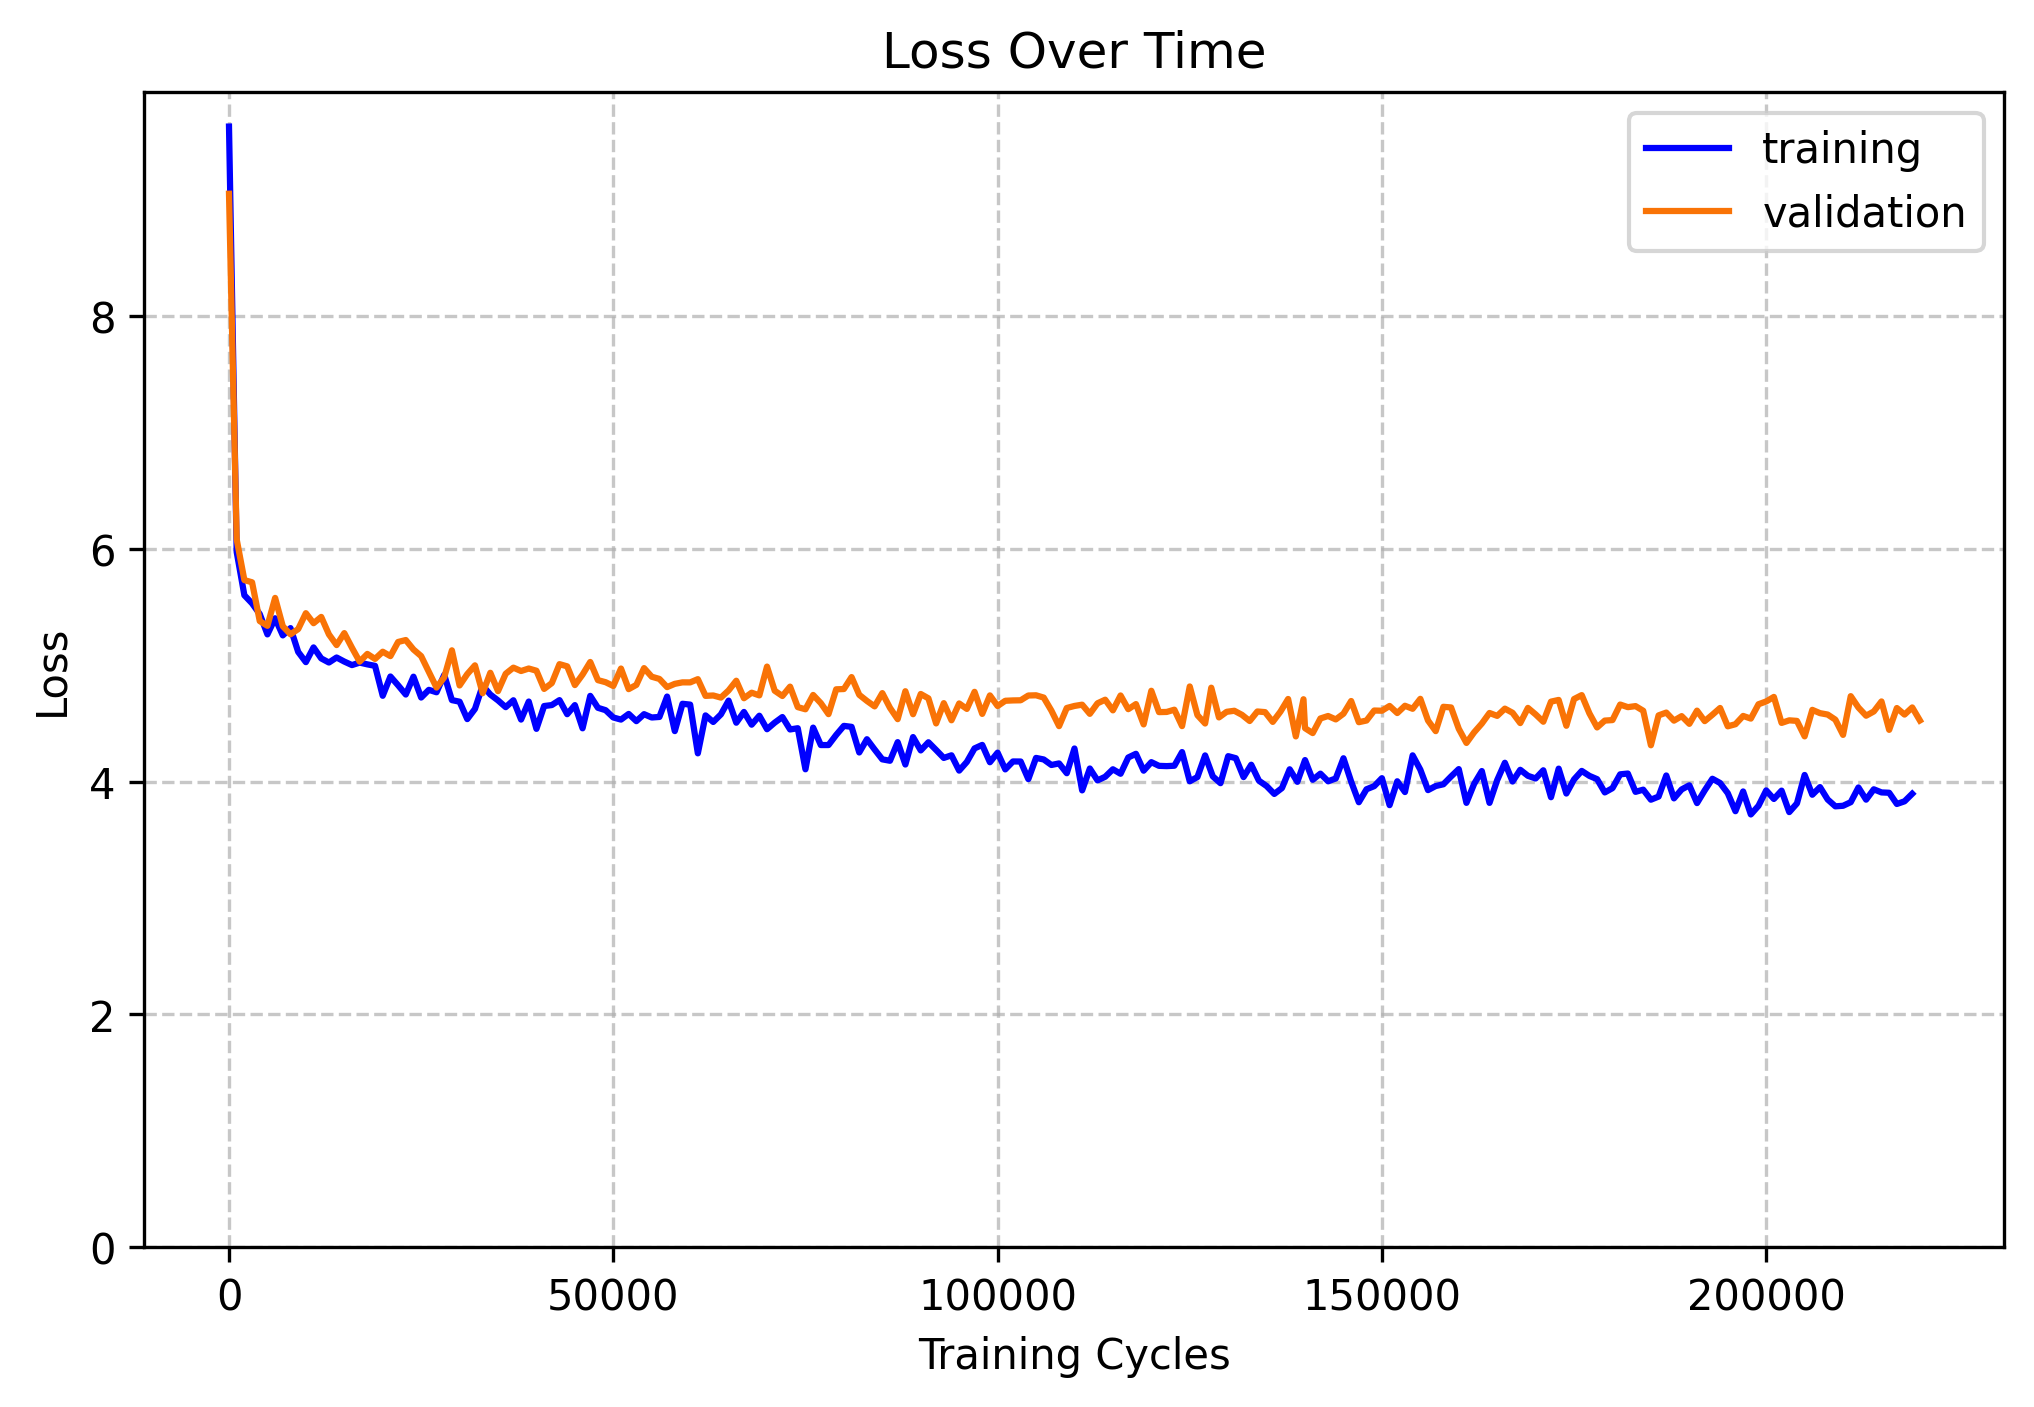

In [70]:
import matplotlib.pyplot as plt
def plot_history(h=history, step=1000):
    train_points = []
    for i in range(len(history['training'])//step):
    #for i in range(1000):
        train_points.append(history['training'][i*step])
    

    cycles_t, train_loss = zip(*train_points)
    cycles_v, val_loss = zip(*history['validation'])
    # TODO: turn the cycle_length into hyper-parameter!
    cycles_per_epoch = len(train_data) / (2 * batch_size * context_len)

    #epochs_t = [cycle / cycles_per_epoch for cycle in cycles_t]
    #epochs_v = [cycle / cycles_per_epoch for cycle in cycles_v]
    plt.figure(figsize=(8, 5), dpi=300)
    t_graph, = plt.plot(cycles_t, train_loss, 'b-')  # 'b-' means blue solid line
    t_graph.set_label("training")
    v_graph, = plt.plot(cycles_v, val_loss, '#f97306')
    v_graph.set_label("validation")

    # Add labels and title
    plt.xlabel('Training Cycles')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()

    # Add grid lines (optional)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optionally, you can set the y-axis to start from 0
    plt.ylim(bottom=0)

    # Display the plot
    plt.show()
        
plot_history()

1
